# 0. 最终的目标
实现对于图像数据的 3 倍超分辨率，并在相关测试集上比较不同模型的结果，综合考虑性能指标（PSNR值）和复杂度指标（模型参数量 & 浮点运算次数）。

In [ ]:
import glob
import os
import copy
import h5py
import math
import torch
from tqdm import tqdm
import PIL.Image as pil_image
import numpy as np
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from thop import profile
from thop import clever_format

需要用到的辅助函数：

In [2]:
class AverageMeter(object):
    def __init__(self):
        self.reset()  # 初始化对象时调用reset()方法

    def reset(self):
        self.val = 0  # 当前值
        self.avg = 0  # 平均值
        self.sum = 0  # 总和
        self.count = 0  # 计数器

    def update(self, val, n=1):
        self.val = val  # 更新当前值
        self.sum += val * n  # 更新总和
        self.count += n  # 更新计数器
        self.avg = self.sum / self.count  # 更新平均值


def calc_psnr(x, y):
    # 计算两张图像的PSNR值
    PSNR = 10. * torch.log10(1. / torch.mean((x - y) ** 2))
    return PSNR


def convert_rgb_to_y(img, dim_order='hwc'):
    # 如果图像维度顺序为(height, width, channel)
    if dim_order == 'hwc':
        # 获取图像的红、绿、蓝通道数据
        red_channel = img[..., 0]
        green_channel = img[..., 1]
        blue_channel = img[..., 2]
        # 根据YUV颜色空间的转换公式计算亮度值
        y = 16. + (64.738 * red_channel + 129.057 * green_channel + 25.064 * blue_channel) / 256.
        return y
    # 如果图像维度顺序为(channel, height, width)
    else:
        # 获取图像的红、绿、蓝通道数据
        red_channel = img[0]
        green_channel = img[1]
        blue_channel = img[2]
        # 根据YUV颜色空间的转换公式计算亮度值
        y = 16. + (64.738 * red_channel + 129.057 * green_channel + 25.064 * blue_channel) / 256.
        return y

# 1. 数据集描述
训练数据集：采用 91images 数据集，共 91 张自然图像，通过裁剪生成大小为 51 * 51 的 HR_Patch，裁剪步长为 13。对于前置上采样模型，对应的 LR_Patch
大小为 17 * 17，即直接由双三次下采样所得；而对于后置上采样模型，LR_Patch 大小仍为 51 * 51，即需要额外一步双三次上采样。处理后的数据保存为 h5 格式。
其中前置上采样模型所需的数据位于 `dataset\pre_sampling` 中；后置上采样模型所需的数据位于 `dataset\post_sampling` 中。

验证数据集：采用 set5 数据集，共 5 张自然图像，处理过程与训练数据集一致，仅是未裁剪为 Patch。  

测试数据集：采用 set14 数据集，共 14 张自然图像，处理过程与训练数据集一致，仅是未裁剪为 Patch。

In [3]:
class GenDataSet(object):
    def __init__(self, type):
        self.train_dir = 'data\91-images'
        self.eval_dir = 'data\Set5'
        self.test_dir = 'data\Set14'
        self.type = type
        self.scale = 3
        self.patch_size = 17 # 生成训练数据时，裁剪的 LR Patch 大小
        self.stride = 13 # 裁剪 Patch 时，滑动的步长
        # 两种 type，分别为前置上采样与后置上采样
        if self.type == 'pre':
            self.output_dir = 'dataset\pre_sampling'
        elif self.type == 'post':
            self.output_dir = 'dataset\post_sampling'
        
    def gen_train(self):
        h5_file = h5py.File(os.path.join(self.output_dir, 'train.h5'), 'w')
        lr_patches = []
        hr_patches = []
        for image_path in sorted(glob.glob('{}/*'.format(self.train_dir))):
            hr = pil_image.open(image_path).convert('RGB')
            hr_width = (hr.width // self.scale) * self.scale
            hr_height = (hr.height // self.scale) * self.scale
            hr = hr.resize((hr_width, hr_height), resample=pil_image.Resampling.BICUBIC)
            lr = hr.resize((hr_width // self.scale, hr_height // self.scale), resample=pil_image.Resampling.BICUBIC)
            # 如果为前置上采样的话，需要额外进行一次双三次插值，保证LR图像的大小与HR一致
            if self.type == 'pre':
                lr = lr.resize((lr.width * self.scale, lr.height * self.scale), resample=pil_image.Resampling.BICUBIC)
            hr = np.array(hr).astype(np.float32)
            lr = np.array(lr).astype(np.float32)
            hr = convert_rgb_to_y(hr)
            lr = convert_rgb_to_y(lr)
            # 注意前置上采样与后置上采样得到的 patch 总数不一样
            if self.type == 'post':
                for i in range(0, lr.shape[0] - self.patch_size + 1, self.stride):
                    for j in range(0, lr.shape[1] - self.patch_size + 1, self.stride):
                        lr_patches.append(lr[i:i + self.patch_size, j:j + self.patch_size])
                        hr_patches.append(hr[i * self.scale:i * self.scale + self.patch_size * self.scale, j * self.scale:j * self.scale + self.patch_size * self.scale])
            elif self.type == 'pre':
                for i in range(0, lr.shape[0] - self.patch_size * self.scale + 1, self.stride):
                    for j in range(0, lr.shape[1] - self.patch_size * self.scale + 1, self.stride):
                        lr_patches.append(lr[i:i + self.patch_size * self.scale, j:j + self.patch_size * self.scale])
                        hr_patches.append(hr[i:i + self.patch_size * self.scale, j:j + self.patch_size * self.scale])
        lr_patches = np.array(lr_patches)
        hr_patches = np.array(hr_patches)
        h5_file.create_dataset('lr', data=lr_patches)
        h5_file.create_dataset('hr', data=hr_patches)
        h5_file.close()

    def gen_eval(self):
        h5_file = h5py.File(os.path.join(self.output_dir, 'eval.h5'), 'w')
        lr_group = h5_file.create_group('lr')
        hr_group = h5_file.create_group('hr')
        for i, image_path in enumerate(sorted(glob.glob('{}/*'.format(self.eval_dir)))):
            hr = pil_image.open(image_path).convert('RGB')
            hr_width = (hr.width // self.scale) * self.scale
            hr_height = (hr.height // self.scale) * self.scale
            hr = hr.resize((hr_width, hr_height), resample=pil_image.Resampling.BICUBIC)
            lr = hr.resize((hr.width // self.scale, hr_height // self.scale), resample=pil_image.Resampling.BICUBIC)
            # 如果为前置上采样的话，需要额外进行一次双三次插值，保证LR图像的大小与HR一致
            if self.type == 'pre':
                lr = lr.resize((lr.width * self.scale, lr.height * self.scale), resample=pil_image.Resampling.BICUBIC)
            hr = np.array(hr).astype(np.float32)
            lr = np.array(lr).astype(np.float32)
            hr = convert_rgb_to_y(hr)
            lr = convert_rgb_to_y(lr)
            lr_group.create_dataset(str(i), data=lr)
            hr_group.create_dataset(str(i), data=hr)
        h5_file.close()

    def gen_test(self):
        h5_file = h5py.File(os.path.join(self.output_dir, 'test.h5'), 'w')
        lr_group = h5_file.create_group('lr')
        hr_group = h5_file.create_group('hr')
        for i, image_path in enumerate(sorted(glob.glob('{}/*'.format(self.test_dir)))):
            hr = pil_image.open(image_path).convert('RGB')
            hr_width = (hr.width // self.scale) * self.scale
            hr_height = (hr.height // self.scale) * self.scale
            hr = hr.resize((hr_width, hr_height), resample=pil_image.Resampling.BICUBIC)
            lr = hr.resize((hr.width // self.scale, hr_height // self.scale), resample=pil_image.Resampling.BICUBIC)
            # 如果为前置上采样的话，需要额外进行一次双三次插值，保证LR图像的大小与HR一致
            if self.type == 'pre':
                lr = lr.resize((lr.width * self.scale, lr.height * self.scale), resample=pil_image.Resampling.BICUBIC)
            hr = np.array(hr).astype(np.float32)
            lr = np.array(lr).astype(np.float32)
            hr = convert_rgb_to_y(hr)
            lr = convert_rgb_to_y(lr)
            lr_group.create_dataset(str(i), data=lr)
            hr_group.create_dataset(str(i), data=hr)
        h5_file.close()

    def run(self):
        self.gen_train()
        self.gen_eval()
        self.gen_test()
        print(f'{self.type} dataset finished')

生成 h5 格式的训练数据集、验证测试集、测试数据集：

In [4]:
if __name__ == '__main__':
    gendataset1 = GenDataSet(type='pre')
    gendataset1.run()
    gendataset2 = GenDataSet(type='post')
    gendataset2.run()

pre dataset finished
post dataset finished


数据集加载类：

In [5]:
class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_data = h5_file  # 初始化h5文件路径

    def __getitem__(self, idx):
        with h5py.File(self.h5_data, 'r') as f:
            lr = np.expand_dims(f['lr'][idx] / 255., 0)  # 从h5文件中获取lr数据并进行处理
            hr = np.expand_dims(f['hr'][idx] / 255., 0)  # 从h5文件中获取hr数据并进行处理
            return lr, hr  # 返回处理后的lr和hr数据

    def __len__(self):
        with h5py.File(self.h5_data, 'r') as f:
            l = len(f['lr'])  # 获取lr数据的长度
            return l  # 返回数据长度


class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_data = h5_file  # 初始化h5文件路径

    def __getitem__(self, idx):
        with h5py.File(self.h5_data, 'r') as f:
            lr = np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0)  # 从h5文件中获取lr数据并进行处理
            hr = np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)  # 从h5文件中获取hr数据并进行处理
            return lr, hr  # 返回处理后的lr和hr数据

    def __len__(self):
        with h5py.File(self.h5_data, 'r') as f:
            l = len(f['lr'])  # 获取lr数据的长度
            return l  # 返回数据长度

# 2. 模型简述：
(1) SRCNN：超分网络的鼻祖，前置上采样的典范。包含 3 层卷积，分别负责图像块提取、非线性映射以及最终的重建过程，卷积间为 ReLU 激活函数。  

(2) FSRCNN：对 SRCNN 的改进，后置上采样的典范。包含 5 个阶段。首先就是 4 个卷积层（代码中分为了 conv_net1 和 conv_net2）：分别为特征提取、收缩层（为了降低维度，减少计算）、非线性映射和扩展层。最后则是作为后置上采样的转置卷积层。  

(3) ESPCN：提出了另外一种后置上采样的方法：亚像素卷积（卷积 + 周期变换算子）。整体结构为卷积模块 + 亚像素卷积（上采样）模块，与 FSRCNN 类似。  

对于以上网络的改进：  

(4) Res_SRCNN：在 SRCNN 的基础上进行了 3 点改进：首先，将普通卷积替换为了深度可分离卷积（逐通道卷积 + 逐点卷积）；其次，将 ReLU 激活函数替换为 LReLU；最后，加入了全局的残差连接。  

(5) Res_ESPCN：在 ESPCN 的基础上惊醒了 2 点改进：首先，将1层普通卷积替换为了2层深度可分离卷积，且输入、输出通道数相同；其次，加入了局部的残差连接，类似 ResNet 中的 Res_Block，但无BN层。

In [9]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        # 卷积模块：3层卷积结构
        self.conv_net = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_channels, kernel_size=5, padding=2)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return x


class Res_SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(Res_SRCNN, self).__init__()
        # 卷积模块：3层卷积结构
        # 第2层卷积改为了深度可分离卷积，ReLU改为了LReLU，并加入了全局的残差连接
        self.conv_net = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=9, padding=4),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, padding=2, groups=64),
            nn.Conv2d(64, 32, kernel_size=1, padding=0, groups=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, num_channels, kernel_size=5, padding=2)
        )

    def forward(self, x):
        x = self.conv_net(x) + x
        return x


class FSRCNN(nn.Module):
    def __init__(self, scale_factor=3, num_channels=1, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        # 卷积模块1：1层卷积
        self.conv_net1 = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=2),
            nn.PReLU(d)
        )
        # 卷积模块2：m+2层卷积
        self.conv_net2 = [nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s)]
        for _ in range(m):
            self.conv_net2.extend([nn.Conv2d(s, s, kernel_size=3, padding=1), nn.PReLU(s)])
        self.conv_net2.extend([nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d)])
        self.conv_net2 = nn.Sequential(*self.conv_net2)
        # 上采样模块：1层转置卷积
        self.TransConv_net = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=4,
                                            output_padding=scale_factor-1)
        # 参数初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.conv_net1:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.conv_net2:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.TransConv_net.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.TransConv_net.bias.data)

    def forward(self, x):
        x = self.conv_net1(x)
        x = self.conv_net2(x)
        x = self.TransConv_net(x)
        return x


class ESPCN(nn.Module):
    def __init__(self, scale_factor=3, num_channels=1):
        super(ESPCN, self).__init__()
        # 卷积模块：2层卷积
        self.conv_net = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Tanh(),
        )
        # 上采样模块：1层亚像素卷积
        self.PS_net = nn.Sequential(
            nn.Conv2d(32, num_channels * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )
        # 参数初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.conv_net:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.PS_net:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                nn.init.zeros_(m.bias.data)

    def forward(self, x):
        x = self.conv_net(x)
        x = self.PS_net(x)
        return x
    

class Res_ESPCN(nn.Module):
    def __init__(self, scale_factor=3, num_channels=1):
        super(Res_ESPCN, self).__init__()
        # 卷积模块1：1层卷积
        self.conv_net1 = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=5, padding=2),
            nn.Tanh()
        )
        # 卷积模块2：2层深度可分离卷积（逐通道卷积+逐点卷积）
        self.conv_net2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(64, 32, kernel_size=1, padding=0, groups=1),
            nn.Conv2d(32, 32, kernel_size=5, padding=2, groups=32),
            nn.Conv2d(32, 64, kernel_size=1, padding=0, groups=1),
            nn.Tanh()
        )
        # 卷积模块3：2层深度可分离卷积（逐通道卷积+逐点卷积）
        self.conv_net3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(64, 32, kernel_size=1, padding=0, groups=1),
            nn.Conv2d(32, 32, kernel_size=5, padding=2, groups=32),
            nn.Conv2d(32, 64, kernel_size=1, padding=0, groups=1),
            nn.Tanh()
        )
        # 上采样模块：1层亚像素卷积
        self.PS_net = nn.Sequential(
            nn.Conv2d(64, num_channels * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )
        # 参数初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.conv_net1:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.conv_net2:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.conv_net3:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.PS_net:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                nn.init.zeros_(m.bias.data)

    def forward(self, x):
        x = self.conv_net1(x)
        x = self.conv_net2(x) + x
        x = self.conv_net3(x) + x
        x = self.PS_net(x)
        return x

训练类（内部包含验证和测试）：  

其中，batch size 统一设为16，epochs 总数统一设为 200，采用 Adam 优化器。  

但是，每个模型的学习率以及是否加入学习率衰减的情形不同，具体详见代码。

In [10]:
class Trainer(object):
    def __init__(self, model_name):
        self.model_name = model_name
        self.criterion = nn.MSELoss()
        self.scale = 3
        self.batch_size = 16
        self.num_epochs = 200
        self.num_workers = 0
        self.seed = 123
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        if model_name == 'SRCNN':
            self.model = SRCNN().to(self.device)
            self.outputs_dir = 'outputs\SRCNN'
            self.data_dir = 'dataset\pre_sampling'
            self.lr = 1e-4
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        elif model_name == 'Res_SRCNN':
            self.model = Res_SRCNN().to(self.device)
            self.outputs_dir = 'outputs\Res_SRCNN'
            self.data_dir = 'dataset\pre_sampling'
            self.lr = 1e-4
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        elif model_name == 'FSRCNN':
            self.model = FSRCNN().to(self.device)
            self.outputs_dir = 'outputs\FSRCNN'
            self.data_dir = 'dataset\post_sampling'
            self.lr = 1e-3
            self.optimizer = optim.Adam([
                {'params': self.model.conv_net1.parameters()},
                {'params': self.model.conv_net2.parameters()},
                {'params': self.model.TransConv_net.parameters(), 'lr': self.lr * 0.1}
            ], lr=self.lr)

        elif model_name == 'ESPCN':
            self.model = ESPCN().to(self.device)
            self.outputs_dir = 'outputs\ESPCN'
            self.data_dir = 'dataset\post_sampling'
            self.lr = 1e-3
            self.optimizer = optim.Adam([
                {'params': self.model.conv_net.parameters()},
                {'params': self.model.PS_net.parameters(), 'lr': self.lr * 0.1}
            ], lr=self.lr)

        elif model_name == 'Res_ESPCN':
            self.model = Res_ESPCN().to(self.device)
            self.outputs_dir = 'outputs\Res_ESPCN'
            self.data_dir = 'dataset\post_sampling'
            self.lr = 1e-3
            self.optimizer = optim.Adam([
                {'params': self.model.conv_net1.parameters()},
                {'params': self.model.conv_net2.parameters()},
                {'params': self.model.conv_net3.parameters()},
                {'params': self.model.PS_net.parameters(), 'lr': self.lr * 0.1}
            ], lr=self.lr)

        self.train_file = os.path.join(self.data_dir, 'train.h5')
        self.eval_file = os.path.join(self.data_dir, 'eval.h5')
        self.test_file = os.path.join(self.data_dir, 'test.h5')
        print(f'---------- start train {model_name} model ----------')


    def run(self):
        torch.manual_seed(self.seed)
        train_dataset = TrainDataset(self.train_file)
        train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=self.batch_size,
                                shuffle=True,
                                num_workers=self.num_workers,
                                pin_memory=True,
                                drop_last=True)
        eval_dataset = EvalDataset(self.eval_file)
        eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)
        test_dataset = EvalDataset(self.test_file)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=1)

        best_weights = copy.deepcopy(self.model.state_dict())
        best_epoch = 0
        best_psnr = 0.0
        train_loss = []
        eval_psnr = []
        for epoch in range(self.num_epochs):
            if self.model_name == 'ESPCN' or self.model_name == 'Res_ESPCN':
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr * (0.1 ** (epoch // int(self.num_epochs * 0.8)))
            self.model.train()
            epoch_losses = AverageMeter()
            with tqdm(total=(len(train_dataset) - len(train_dataset) % self.batch_size)) as t:
                t.set_description('epoch: {}/{}'.format(epoch, self.num_epochs - 1))
                for data in train_dataloader:
                    inputs, labels = data
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    preds = self.model(inputs)
                    loss = self.criterion(preds, labels)
                    epoch_losses.update(loss.item(), len(inputs))
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
                    t.update(len(inputs))
            train_loss.append(epoch_losses.avg)

            self.model.eval()
            epoch_psnr = AverageMeter()
            for data in eval_dataloader:
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                with torch.no_grad():
                    preds = self.model(inputs).clamp(0.0, 1.0)
                    epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

            eval_psnr.append(epoch_psnr.avg.cpu())
            print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

            if epoch_psnr.avg > best_psnr:
                best_epoch = epoch
                best_psnr = epoch_psnr.avg
                best_weights = copy.deepcopy(self.model.state_dict())

            if epoch % 10 == 0 or epoch == self.num_epochs-1:
                torch.save(self.model.state_dict(), os.path.join(self.outputs_dir, 'epoch_{}.pth'.format(epoch)))
                np.save(os.path.join(self.outputs_dir, 'train_loss.npy'), np.array(train_loss))
                np.save(os.path.join(self.outputs_dir, 'eval_psnr.npy'), np.array(eval_psnr))

        print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
        torch.save(best_weights, os.path.join(self.outputs_dir, 'best.pth'))

        checkpoint = torch.load(os.path.join(self.outputs_dir, 'best.pth'))
        self.model.load_state_dict(checkpoint)
        self.model.eval()
        epoch_psnr = AverageMeter()
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            with torch.no_grad():
                preds = self.model(inputs).clamp(0.0, 1.0)
                epoch_psnr.update(calc_psnr(preds, labels), len(inputs))
                
        flops, params = profile(self.model, inputs=(inputs,))
        flops, params = clever_format([flops, params], '%.3f')
        print('test psnr: {:.2f}'.format(epoch_psnr.avg))
        print('net params: {}'.format(params))
        print('net flops: {}'.format(flops))

# 3. 模型训练过程
包含每个 epoch 的训练损失，验证PSNR，以及最终最优 epoch 下的测试PSNR。

In [51]:
if __name__ == "__main__":
    trainer_1 = Trainer(model_name='SRCNN')
    trainer_1.run()

---------- start train SRCNN model ----------


epoch: 0/199: 100%|██████████| 21440/21440 [00:16<00:00, 1281.91it/s, loss=0.003368]


eval psnr: 32.09


epoch: 1/199: 100%|██████████| 21440/21440 [00:16<00:00, 1286.07it/s, loss=0.001346]


eval psnr: 32.36


epoch: 2/199: 100%|██████████| 21440/21440 [00:16<00:00, 1282.45it/s, loss=0.001305]


eval psnr: 32.50


epoch: 3/199: 100%|██████████| 21440/21440 [00:16<00:00, 1288.77it/s, loss=0.001282]


eval psnr: 32.60


epoch: 4/199: 100%|██████████| 21440/21440 [00:16<00:00, 1287.84it/s, loss=0.001262]


eval psnr: 32.57


epoch: 5/199: 100%|██████████| 21440/21440 [00:16<00:00, 1278.78it/s, loss=0.001246]


eval psnr: 32.57


epoch: 6/199: 100%|██████████| 21440/21440 [00:16<00:00, 1284.52it/s, loss=0.001235]


eval psnr: 32.78


epoch: 7/199: 100%|██████████| 21440/21440 [00:16<00:00, 1298.14it/s, loss=0.001225]


eval psnr: 32.68


epoch: 8/199: 100%|██████████| 21440/21440 [00:16<00:00, 1277.71it/s, loss=0.001216]


eval psnr: 32.83


epoch: 9/199: 100%|██████████| 21440/21440 [00:16<00:00, 1280.61it/s, loss=0.001209]


eval psnr: 32.67


epoch: 10/199: 100%|██████████| 21440/21440 [00:16<00:00, 1278.70it/s, loss=0.001203]


eval psnr: 32.85


epoch: 11/199: 100%|██████████| 21440/21440 [00:16<00:00, 1274.37it/s, loss=0.001198]


eval psnr: 32.91


epoch: 12/199: 100%|██████████| 21440/21440 [00:16<00:00, 1269.54it/s, loss=0.001194]


eval psnr: 32.93


epoch: 13/199: 100%|██████████| 21440/21440 [00:17<00:00, 1259.32it/s, loss=0.001188]


eval psnr: 32.93


epoch: 14/199: 100%|██████████| 21440/21440 [00:17<00:00, 1254.31it/s, loss=0.001183]


eval psnr: 32.91


epoch: 15/199: 100%|██████████| 21440/21440 [00:17<00:00, 1260.58it/s, loss=0.001179]


eval psnr: 32.96


epoch: 16/199: 100%|██████████| 21440/21440 [00:16<00:00, 1277.86it/s, loss=0.001176]


eval psnr: 32.96


epoch: 17/199: 100%|██████████| 21440/21440 [00:15<00:00, 1364.91it/s, loss=0.001173]


eval psnr: 32.92


epoch: 18/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.27it/s, loss=0.001170]


eval psnr: 32.96


epoch: 19/199: 100%|██████████| 21440/21440 [00:15<00:00, 1387.16it/s, loss=0.001166]


eval psnr: 32.96


epoch: 20/199: 100%|██████████| 21440/21440 [00:15<00:00, 1386.80it/s, loss=0.001164]


eval psnr: 33.01


epoch: 21/199: 100%|██████████| 21440/21440 [00:15<00:00, 1384.57it/s, loss=0.001162]


eval psnr: 33.03


epoch: 22/199: 100%|██████████| 21440/21440 [00:15<00:00, 1352.43it/s, loss=0.001160]


eval psnr: 32.97


epoch: 23/199: 100%|██████████| 21440/21440 [00:16<00:00, 1263.26it/s, loss=0.001157]


eval psnr: 32.99


epoch: 24/199: 100%|██████████| 21440/21440 [00:17<00:00, 1254.09it/s, loss=0.001155]


eval psnr: 33.02


epoch: 25/199: 100%|██████████| 21440/21440 [00:16<00:00, 1274.60it/s, loss=0.001153]


eval psnr: 33.00


epoch: 26/199: 100%|██████████| 21440/21440 [00:16<00:00, 1280.69it/s, loss=0.001151]


eval psnr: 33.04


epoch: 27/199: 100%|██████████| 21440/21440 [00:16<00:00, 1280.08it/s, loss=0.001149]


eval psnr: 33.00


epoch: 28/199: 100%|██████████| 21440/21440 [00:16<00:00, 1331.02it/s, loss=0.001147]


eval psnr: 33.04


epoch: 29/199: 100%|██████████| 21440/21440 [00:15<00:00, 1375.24it/s, loss=0.001145]


eval psnr: 33.04


epoch: 30/199: 100%|██████████| 21440/21440 [00:15<00:00, 1359.97it/s, loss=0.001144]


eval psnr: 33.00


epoch: 31/199: 100%|██████████| 21440/21440 [00:17<00:00, 1255.34it/s, loss=0.001142]


eval psnr: 33.08


epoch: 32/199: 100%|██████████| 21440/21440 [00:16<00:00, 1264.52it/s, loss=0.001140]


eval psnr: 33.05


epoch: 33/199: 100%|██████████| 21440/21440 [00:17<00:00, 1258.36it/s, loss=0.001139]


eval psnr: 33.08


epoch: 34/199: 100%|██████████| 21440/21440 [00:16<00:00, 1266.62it/s, loss=0.001138]


eval psnr: 33.10


epoch: 35/199: 100%|██████████| 21440/21440 [00:16<00:00, 1331.59it/s, loss=0.001136]


eval psnr: 33.07


epoch: 36/199: 100%|██████████| 21440/21440 [00:15<00:00, 1359.37it/s, loss=0.001135]


eval psnr: 33.09


epoch: 37/199: 100%|██████████| 21440/21440 [00:15<00:00, 1356.36it/s, loss=0.001134]


eval psnr: 33.13


epoch: 38/199: 100%|██████████| 21440/21440 [00:15<00:00, 1340.17it/s, loss=0.001133]


eval psnr: 33.12


epoch: 39/199: 100%|██████████| 21440/21440 [00:15<00:00, 1345.12it/s, loss=0.001131]


eval psnr: 33.14


epoch: 40/199: 100%|██████████| 21440/21440 [00:15<00:00, 1350.72it/s, loss=0.001130]


eval psnr: 33.12


epoch: 41/199: 100%|██████████| 21440/21440 [00:15<00:00, 1365.26it/s, loss=0.001129]


eval psnr: 33.08


epoch: 42/199: 100%|██████████| 21440/21440 [00:15<00:00, 1375.42it/s, loss=0.001127]


eval psnr: 33.11


epoch: 43/199: 100%|██████████| 21440/21440 [00:15<00:00, 1354.13it/s, loss=0.001127]


eval psnr: 33.08


epoch: 44/199: 100%|██████████| 21440/21440 [00:16<00:00, 1285.99it/s, loss=0.001126]


eval psnr: 33.11


epoch: 45/199: 100%|██████████| 21440/21440 [00:17<00:00, 1257.92it/s, loss=0.001124]


eval psnr: 33.14


epoch: 46/199: 100%|██████████| 21440/21440 [00:16<00:00, 1268.41it/s, loss=0.001124]


eval psnr: 33.16


epoch: 47/199: 100%|██████████| 21440/21440 [00:15<00:00, 1342.43it/s, loss=0.001123]


eval psnr: 33.11


epoch: 48/199: 100%|██████████| 21440/21440 [00:15<00:00, 1363.43it/s, loss=0.001122]


eval psnr: 33.17


epoch: 49/199: 100%|██████████| 21440/21440 [00:15<00:00, 1376.21it/s, loss=0.001121]


eval psnr: 32.91


epoch: 50/199: 100%|██████████| 21440/21440 [00:15<00:00, 1373.21it/s, loss=0.001120]


eval psnr: 33.16


epoch: 51/199: 100%|██████████| 21440/21440 [00:15<00:00, 1376.83it/s, loss=0.001120]


eval psnr: 33.13


epoch: 52/199: 100%|██████████| 21440/21440 [00:15<00:00, 1343.61it/s, loss=0.001119]


eval psnr: 33.12


epoch: 53/199: 100%|██████████| 21440/21440 [00:15<00:00, 1364.74it/s, loss=0.001118]


eval psnr: 33.11


epoch: 54/199: 100%|██████████| 21440/21440 [00:15<00:00, 1369.97it/s, loss=0.001117]


eval psnr: 33.14


epoch: 55/199: 100%|██████████| 21440/21440 [00:15<00:00, 1412.01it/s, loss=0.001117]


eval psnr: 33.15


epoch: 56/199: 100%|██████████| 21440/21440 [00:15<00:00, 1386.27it/s, loss=0.001115]


eval psnr: 33.14


epoch: 57/199: 100%|██████████| 21440/21440 [00:15<00:00, 1363.69it/s, loss=0.001115]


eval psnr: 33.16


epoch: 58/199: 100%|██████████| 21440/21440 [00:15<00:00, 1357.99it/s, loss=0.001114]


eval psnr: 33.12


epoch: 59/199: 100%|██████████| 21440/21440 [00:15<00:00, 1365.95it/s, loss=0.001114]


eval psnr: 33.15


epoch: 60/199: 100%|██████████| 21440/21440 [00:15<00:00, 1370.41it/s, loss=0.001113]


eval psnr: 33.15


epoch: 61/199: 100%|██████████| 21440/21440 [00:15<00:00, 1367.96it/s, loss=0.001112]


eval psnr: 33.17


epoch: 62/199: 100%|██████████| 21440/21440 [00:15<00:00, 1356.96it/s, loss=0.001112]


eval psnr: 33.15


epoch: 63/199: 100%|██████████| 21440/21440 [00:15<00:00, 1376.48it/s, loss=0.001111]


eval psnr: 33.10


epoch: 64/199: 100%|██████████| 21440/21440 [00:15<00:00, 1375.33it/s, loss=0.001110]


eval psnr: 33.15


epoch: 65/199: 100%|██████████| 21440/21440 [00:15<00:00, 1363.61it/s, loss=0.001110]


eval psnr: 33.09


epoch: 66/199: 100%|██████████| 21440/21440 [00:15<00:00, 1361.62it/s, loss=0.001108]


eval psnr: 33.14


epoch: 67/199: 100%|██████████| 21440/21440 [00:15<00:00, 1386.09it/s, loss=0.001109]


eval psnr: 33.15


epoch: 68/199: 100%|██████████| 21440/21440 [00:15<00:00, 1399.20it/s, loss=0.001108]


eval psnr: 33.15


epoch: 69/199: 100%|██████████| 21440/21440 [00:15<00:00, 1365.78it/s, loss=0.001107]


eval psnr: 33.19


epoch: 70/199: 100%|██████████| 21440/21440 [00:15<00:00, 1351.32it/s, loss=0.001107]


eval psnr: 33.21


epoch: 71/199: 100%|██████████| 21440/21440 [00:16<00:00, 1318.90it/s, loss=0.001106]


eval psnr: 33.19


epoch: 72/199: 100%|██████████| 21440/21440 [00:15<00:00, 1369.88it/s, loss=0.001106]


eval psnr: 33.16


epoch: 73/199: 100%|██████████| 21440/21440 [00:15<00:00, 1378.78it/s, loss=0.001105]


eval psnr: 33.14


epoch: 74/199: 100%|██████████| 21440/21440 [00:16<00:00, 1331.51it/s, loss=0.001105]


eval psnr: 33.12


epoch: 75/199: 100%|██████████| 21440/21440 [00:15<00:00, 1347.50it/s, loss=0.001104]


eval psnr: 33.18


epoch: 76/199: 100%|██████████| 21440/21440 [00:15<00:00, 1368.22it/s, loss=0.001103]


eval psnr: 33.11


epoch: 77/199: 100%|██████████| 21440/21440 [00:16<00:00, 1330.85it/s, loss=0.001103]


eval psnr: 33.15


epoch: 78/199: 100%|██████████| 21440/21440 [00:15<00:00, 1349.53it/s, loss=0.001103]


eval psnr: 33.16


epoch: 79/199: 100%|██████████| 21440/21440 [00:15<00:00, 1371.28it/s, loss=0.001102]


eval psnr: 33.19


epoch: 80/199: 100%|██████████| 21440/21440 [00:15<00:00, 1346.99it/s, loss=0.001101]


eval psnr: 33.21


epoch: 81/199: 100%|██████████| 21440/21440 [00:15<00:00, 1343.36it/s, loss=0.001101]


eval psnr: 33.19


epoch: 82/199: 100%|██████████| 21440/21440 [00:16<00:00, 1329.28it/s, loss=0.001101]


eval psnr: 33.17


epoch: 83/199: 100%|██████████| 21440/21440 [00:15<00:00, 1353.96it/s, loss=0.001100]


eval psnr: 33.19


epoch: 84/199: 100%|██████████| 21440/21440 [00:15<00:00, 1372.34it/s, loss=0.001100]


eval psnr: 33.17


epoch: 85/199: 100%|██████████| 21440/21440 [00:15<00:00, 1353.62it/s, loss=0.001100]


eval psnr: 33.18


epoch: 86/199: 100%|██████████| 21440/21440 [00:15<00:00, 1344.20it/s, loss=0.001099]


eval psnr: 33.21


epoch: 87/199: 100%|██████████| 21440/21440 [00:16<00:00, 1272.86it/s, loss=0.001098]


eval psnr: 33.19


epoch: 88/199: 100%|██████████| 21440/21440 [00:15<00:00, 1351.49it/s, loss=0.001098]


eval psnr: 33.12


epoch: 89/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.89it/s, loss=0.001097]


eval psnr: 33.20


epoch: 90/199: 100%|██████████| 21440/21440 [00:15<00:00, 1388.60it/s, loss=0.001098]


eval psnr: 33.18


epoch: 91/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.44it/s, loss=0.001096]


eval psnr: 33.20


epoch: 92/199: 100%|██████████| 21440/21440 [00:15<00:00, 1382.33it/s, loss=0.001096]


eval psnr: 33.19


epoch: 93/199: 100%|██████████| 21440/21440 [00:15<00:00, 1388.78it/s, loss=0.001096]


eval psnr: 33.18


epoch: 94/199: 100%|██████████| 21440/21440 [00:15<00:00, 1380.91it/s, loss=0.001096]


eval psnr: 33.20


epoch: 95/199: 100%|██████████| 21440/21440 [00:15<00:00, 1353.45it/s, loss=0.001095]


eval psnr: 33.19


epoch: 96/199: 100%|██████████| 21440/21440 [00:16<00:00, 1306.76it/s, loss=0.001095]


eval psnr: 33.14


epoch: 97/199: 100%|██████████| 21440/21440 [00:17<00:00, 1253.43it/s, loss=0.001094]


eval psnr: 33.17


epoch: 98/199: 100%|██████████| 21440/21440 [00:16<00:00, 1279.16it/s, loss=0.001095]


eval psnr: 33.22


epoch: 99/199: 100%|██████████| 21440/21440 [00:15<00:00, 1352.00it/s, loss=0.001094]


eval psnr: 33.18


epoch: 100/199: 100%|██████████| 21440/21440 [00:15<00:00, 1376.39it/s, loss=0.001093]


eval psnr: 33.18


epoch: 101/199: 100%|██████████| 21440/21440 [00:15<00:00, 1371.72it/s, loss=0.001093]


eval psnr: 33.18


epoch: 102/199: 100%|██████████| 21440/21440 [00:15<00:00, 1370.23it/s, loss=0.001093]


eval psnr: 33.18


epoch: 103/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.23it/s, loss=0.001093]


eval psnr: 33.20


epoch: 104/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.44it/s, loss=0.001092]


eval psnr: 33.20


epoch: 105/199: 100%|██████████| 21440/21440 [00:15<00:00, 1363.26it/s, loss=0.001092]


eval psnr: 33.22


epoch: 106/199: 100%|██████████| 21440/21440 [00:15<00:00, 1342.01it/s, loss=0.001091]


eval psnr: 33.22


epoch: 107/199: 100%|██████████| 21440/21440 [00:15<00:00, 1359.03it/s, loss=0.001092]


eval psnr: 33.21


epoch: 108/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.67it/s, loss=0.001091]


eval psnr: 33.18


epoch: 109/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.58it/s, loss=0.001091]


eval psnr: 33.18


epoch: 110/199: 100%|██████████| 21440/21440 [00:15<00:00, 1380.55it/s, loss=0.001090]


eval psnr: 33.21


epoch: 111/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.58it/s, loss=0.001090]


eval psnr: 33.20


epoch: 112/199: 100%|██████████| 21440/21440 [00:15<00:00, 1376.65it/s, loss=0.001089]


eval psnr: 33.15


epoch: 113/199: 100%|██████████| 21440/21440 [00:16<00:00, 1294.92it/s, loss=0.001089]


eval psnr: 33.17


epoch: 114/199: 100%|██████████| 21440/21440 [00:17<00:00, 1244.05it/s, loss=0.001089]


eval psnr: 33.18


epoch: 115/199: 100%|██████████| 21440/21440 [00:17<00:00, 1249.49it/s, loss=0.001088]


eval psnr: 33.15


epoch: 116/199: 100%|██████████| 21440/21440 [00:16<00:00, 1275.51it/s, loss=0.001088]


eval psnr: 33.22


epoch: 117/199: 100%|██████████| 21440/21440 [00:17<00:00, 1253.80it/s, loss=0.001088]


eval psnr: 33.18


epoch: 118/199: 100%|██████████| 21440/21440 [00:17<00:00, 1258.14it/s, loss=0.001088]


eval psnr: 33.19


epoch: 119/199: 100%|██████████| 21440/21440 [00:16<00:00, 1330.02it/s, loss=0.001087]


eval psnr: 33.21


epoch: 120/199: 100%|██████████| 21440/21440 [00:16<00:00, 1332.50it/s, loss=0.001087]


eval psnr: 33.17


epoch: 121/199: 100%|██████████| 21440/21440 [00:16<00:00, 1316.39it/s, loss=0.001087]


eval psnr: 33.17


epoch: 122/199: 100%|██████████| 21440/21440 [00:15<00:00, 1341.93it/s, loss=0.001086]


eval psnr: 33.22


epoch: 123/199: 100%|██████████| 21440/21440 [00:16<00:00, 1334.83it/s, loss=0.001086]


eval psnr: 33.17


epoch: 124/199: 100%|██████████| 21440/21440 [00:16<00:00, 1325.17it/s, loss=0.001086]


eval psnr: 33.21


epoch: 125/199: 100%|██████████| 21440/21440 [00:16<00:00, 1332.34it/s, loss=0.001086]


eval psnr: 33.20


epoch: 126/199: 100%|██████████| 21440/21440 [00:15<00:00, 1349.36it/s, loss=0.001085]


eval psnr: 33.20


epoch: 127/199: 100%|██████████| 21440/21440 [00:16<00:00, 1334.83it/s, loss=0.001086]


eval psnr: 33.25


epoch: 128/199: 100%|██████████| 21440/21440 [00:16<00:00, 1328.79it/s, loss=0.001085]


eval psnr: 33.20


epoch: 129/199: 100%|██████████| 21440/21440 [00:15<00:00, 1359.20it/s, loss=0.001085]


eval psnr: 33.20


epoch: 130/199: 100%|██████████| 21440/21440 [00:16<00:00, 1329.61it/s, loss=0.001085]


eval psnr: 33.23


epoch: 131/199: 100%|██████████| 21440/21440 [00:16<00:00, 1304.14it/s, loss=0.001083]


eval psnr: 33.18


epoch: 132/199: 100%|██████████| 21440/21440 [00:17<00:00, 1249.34it/s, loss=0.001084]


eval psnr: 33.23


epoch: 133/199: 100%|██████████| 21440/21440 [00:16<00:00, 1264.15it/s, loss=0.001084]


eval psnr: 33.24


epoch: 134/199: 100%|██████████| 21440/21440 [00:16<00:00, 1331.93it/s, loss=0.001083]


eval psnr: 33.24


epoch: 135/199: 100%|██████████| 21440/21440 [00:15<00:00, 1378.42it/s, loss=0.001083]


eval psnr: 33.21


epoch: 136/199: 100%|██████████| 21440/21440 [00:15<00:00, 1384.57it/s, loss=0.001083]


eval psnr: 33.20


epoch: 137/199: 100%|██████████| 21440/21440 [00:15<00:00, 1382.42it/s, loss=0.001082]


eval psnr: 33.20


epoch: 138/199: 100%|██████████| 21440/21440 [00:15<00:00, 1382.96it/s, loss=0.001083]


eval psnr: 33.21


epoch: 139/199: 100%|██████████| 21440/21440 [00:15<00:00, 1361.87it/s, loss=0.001082]


eval psnr: 33.21


epoch: 140/199: 100%|██████████| 21440/21440 [00:15<00:00, 1357.91it/s, loss=0.001081]


eval psnr: 33.18


epoch: 141/199: 100%|██████████| 21440/21440 [00:16<00:00, 1300.02it/s, loss=0.001082]


eval psnr: 33.20


epoch: 142/199: 100%|██████████| 21440/21440 [00:16<00:00, 1323.54it/s, loss=0.001081]


eval psnr: 33.14


epoch: 143/199: 100%|██████████| 21440/21440 [00:16<00:00, 1304.77it/s, loss=0.001081]


eval psnr: 33.24


epoch: 144/199: 100%|██████████| 21440/21440 [00:16<00:00, 1328.21it/s, loss=0.001081]


eval psnr: 33.24


epoch: 145/199: 100%|██████████| 21440/21440 [00:16<00:00, 1313.48it/s, loss=0.001081]


eval psnr: 33.22


epoch: 146/199: 100%|██████████| 21440/21440 [00:15<00:00, 1348.60it/s, loss=0.001080]


eval psnr: 33.24


epoch: 147/199: 100%|██████████| 21440/21440 [00:15<00:00, 1345.47it/s, loss=0.001080]


eval psnr: 33.19


epoch: 148/199: 100%|██████████| 21440/21440 [00:16<00:00, 1313.16it/s, loss=0.001080]


eval psnr: 32.98


epoch: 149/199: 100%|██████████| 21440/21440 [00:15<00:00, 1348.68it/s, loss=0.001080]


eval psnr: 33.21


epoch: 150/199: 100%|██████████| 21440/21440 [00:15<00:00, 1343.44it/s, loss=0.001079]


eval psnr: 33.22


epoch: 151/199: 100%|██████████| 21440/21440 [00:15<00:00, 1355.42it/s, loss=0.001079]


eval psnr: 33.26


epoch: 152/199: 100%|██████████| 21440/21440 [00:15<00:00, 1366.04it/s, loss=0.001079]


eval psnr: 33.24


epoch: 153/199: 100%|██████████| 21440/21440 [00:16<00:00, 1297.82it/s, loss=0.001079]


eval psnr: 33.19


epoch: 154/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.84it/s, loss=0.001078]


eval psnr: 33.23


epoch: 155/199: 100%|██████████| 21440/21440 [00:16<00:00, 1302.71it/s, loss=0.001078]


eval psnr: 33.17


epoch: 156/199: 100%|██████████| 21440/21440 [00:16<00:00, 1327.88it/s, loss=0.001078]


eval psnr: 33.22


epoch: 157/199: 100%|██████████| 21440/21440 [00:16<00:00, 1331.26it/s, loss=0.001078]


eval psnr: 33.23


epoch: 158/199: 100%|██████████| 21440/21440 [00:16<00:00, 1339.25it/s, loss=0.001078]


eval psnr: 33.24


epoch: 159/199: 100%|██████████| 21440/21440 [00:16<00:00, 1338.74it/s, loss=0.001077]


eval psnr: 33.21


epoch: 160/199: 100%|██████████| 21440/21440 [00:17<00:00, 1251.31it/s, loss=0.001077]


eval psnr: 33.17


epoch: 161/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.82it/s, loss=0.001077]


eval psnr: 33.20


epoch: 162/199: 100%|██████████| 21440/21440 [00:17<00:00, 1248.76it/s, loss=0.001077]


eval psnr: 33.21


epoch: 163/199: 100%|██████████| 21440/21440 [00:17<00:00, 1250.07it/s, loss=0.001077]


eval psnr: 33.23


epoch: 164/199: 100%|██████████| 21440/21440 [00:16<00:00, 1270.44it/s, loss=0.001076]


eval psnr: 33.21


epoch: 165/199: 100%|██████████| 21440/21440 [00:16<00:00, 1285.22it/s, loss=0.001076]


eval psnr: 33.21


epoch: 166/199: 100%|██████████| 21440/21440 [00:16<00:00, 1284.60it/s, loss=0.001076]


eval psnr: 33.12


epoch: 167/199: 100%|██████████| 21440/21440 [00:16<00:00, 1287.38it/s, loss=0.001076]


eval psnr: 33.19


epoch: 168/199: 100%|██████████| 21440/21440 [00:16<00:00, 1266.62it/s, loss=0.001076]


eval psnr: 33.21


epoch: 169/199: 100%|██████████| 21440/21440 [00:16<00:00, 1291.88it/s, loss=0.001075]


eval psnr: 33.17


epoch: 170/199: 100%|██████████| 21440/21440 [00:15<00:00, 1359.28it/s, loss=0.001075]


eval psnr: 33.21


epoch: 171/199: 100%|██████████| 21440/21440 [00:15<00:00, 1373.04it/s, loss=0.001075]


eval psnr: 33.19


epoch: 172/199: 100%|██████████| 21440/21440 [00:15<00:00, 1377.98it/s, loss=0.001075]


eval psnr: 33.12


epoch: 173/199: 100%|██████████| 21440/21440 [00:15<00:00, 1348.94it/s, loss=0.001074]


eval psnr: 33.21


epoch: 174/199: 100%|██████████| 21440/21440 [00:16<00:00, 1336.57it/s, loss=0.001075]


eval psnr: 33.18


epoch: 175/199: 100%|██████████| 21440/21440 [00:16<00:00, 1332.84it/s, loss=0.001074]


eval psnr: 33.23


epoch: 176/199: 100%|██████████| 21440/21440 [00:15<00:00, 1364.39it/s, loss=0.001074]


eval psnr: 33.25


epoch: 177/199: 100%|██████████| 21440/21440 [00:15<00:00, 1365.17it/s, loss=0.001074]


eval psnr: 33.20


epoch: 178/199: 100%|██████████| 21440/21440 [00:15<00:00, 1375.06it/s, loss=0.001073]


eval psnr: 33.20


epoch: 179/199: 100%|██████████| 21440/21440 [00:15<00:00, 1348.94it/s, loss=0.001073]


eval psnr: 33.23


epoch: 180/199: 100%|██████████| 21440/21440 [00:16<00:00, 1328.05it/s, loss=0.001073]


eval psnr: 33.22


epoch: 181/199: 100%|██████████| 21440/21440 [00:15<00:00, 1342.01it/s, loss=0.001074]


eval psnr: 33.17


epoch: 182/199: 100%|██████████| 21440/21440 [00:15<00:00, 1347.33it/s, loss=0.001072]


eval psnr: 33.15


epoch: 183/199: 100%|██████████| 21440/21440 [00:15<00:00, 1342.60it/s, loss=0.001073]


eval psnr: 33.24


epoch: 184/199: 100%|██████████| 21440/21440 [00:16<00:00, 1337.49it/s, loss=0.001073]


eval psnr: 33.20


epoch: 185/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.98it/s, loss=0.001072]


eval psnr: 33.19


epoch: 186/199: 100%|██████████| 21440/21440 [00:15<00:00, 1382.96it/s, loss=0.001072]


eval psnr: 33.22


epoch: 187/199: 100%|██████████| 21440/21440 [00:15<00:00, 1380.82it/s, loss=0.001072]


eval psnr: 33.13


epoch: 188/199: 100%|██████████| 21440/21440 [00:15<00:00, 1378.96it/s, loss=0.001072]


eval psnr: 33.22


epoch: 189/199: 100%|██████████| 21440/21440 [00:15<00:00, 1364.91it/s, loss=0.001072]


eval psnr: 33.22


epoch: 190/199: 100%|██████████| 21440/21440 [00:15<00:00, 1367.78it/s, loss=0.001071]


eval psnr: 33.20


epoch: 191/199: 100%|██████████| 21440/21440 [00:15<00:00, 1353.02it/s, loss=0.001071]


eval psnr: 33.22


epoch: 192/199: 100%|██████████| 21440/21440 [00:15<00:00, 1379.22it/s, loss=0.001071]


eval psnr: 33.21


epoch: 193/199: 100%|██████████| 21440/21440 [00:15<00:00, 1384.30it/s, loss=0.001071]


eval psnr: 33.21


epoch: 194/199: 100%|██████████| 21440/21440 [00:15<00:00, 1381.98it/s, loss=0.001071]


eval psnr: 33.23


epoch: 195/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.31it/s, loss=0.001071]


eval psnr: 33.20


epoch: 196/199: 100%|██████████| 21440/21440 [00:15<00:00, 1383.40it/s, loss=0.001070]


eval psnr: 33.22


epoch: 197/199: 100%|██████████| 21440/21440 [00:15<00:00, 1346.40it/s, loss=0.001070]


eval psnr: 33.17


epoch: 198/199: 100%|██████████| 21440/21440 [00:15<00:00, 1356.88it/s, loss=0.001070]


eval psnr: 33.21


epoch: 199/199: 100%|██████████| 21440/21440 [00:15<00:00, 1356.02it/s, loss=0.001069]


eval psnr: 33.25
best epoch: 151, psnr: 33.26
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
test psnr: 29.55
net params: 57.281K
net flops: 13.047G


In [93]:
if __name__ == "__main__":    
    trainer_2 = Trainer(model_name='FSRCNN')
    trainer_2.run()

---------- start train FSRCNN model ----------


epoch: 0/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.02it/s, loss=0.030563]


eval psnr: 23.29


epoch: 1/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.84it/s, loss=0.005466]


eval psnr: 26.52


epoch: 2/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.11it/s, loss=0.003998]


eval psnr: 27.54


epoch: 3/199: 100%|██████████| 2688/2688 [00:03<00:00, 806.23it/s, loss=0.003390]


eval psnr: 28.52


epoch: 4/199: 100%|██████████| 2688/2688 [00:03<00:00, 799.03it/s, loss=0.002826]


eval psnr: 29.20


epoch: 5/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.31it/s, loss=0.002611]


eval psnr: 29.53


epoch: 6/199: 100%|██████████| 2688/2688 [00:03<00:00, 815.29it/s, loss=0.002316]


eval psnr: 29.53


epoch: 7/199: 100%|██████████| 2688/2688 [00:03<00:00, 845.05it/s, loss=0.002172]


eval psnr: 30.24


epoch: 8/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.11it/s, loss=0.002124]


eval psnr: 30.60


epoch: 9/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.28it/s, loss=0.001918]


eval psnr: 30.06


epoch: 10/199: 100%|██████████| 2688/2688 [00:03<00:00, 844.25it/s, loss=0.001829]


eval psnr: 31.07


epoch: 11/199: 100%|██████████| 2688/2688 [00:03<00:00, 844.51it/s, loss=0.001850]


eval psnr: 31.20


epoch: 12/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.28it/s, loss=0.001693]


eval psnr: 31.33


epoch: 13/199: 100%|██████████| 2688/2688 [00:03<00:00, 844.25it/s, loss=0.001706]


eval psnr: 30.82


epoch: 14/199: 100%|██████████| 2688/2688 [00:03<00:00, 841.34it/s, loss=0.001623]


eval psnr: 31.50


epoch: 15/199: 100%|██████████| 2688/2688 [00:03<00:00, 841.87it/s, loss=0.001631]


eval psnr: 31.62


epoch: 16/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.41it/s, loss=0.001650]


eval psnr: 31.62


epoch: 17/199: 100%|██████████| 2688/2688 [00:03<00:00, 861.31it/s, loss=0.001547]


eval psnr: 31.75


epoch: 18/199: 100%|██████████| 2688/2688 [00:03<00:00, 838.97it/s, loss=0.001587]


eval psnr: 31.75


epoch: 19/199: 100%|██████████| 2688/2688 [00:03<00:00, 841.60it/s, loss=0.001526]


eval psnr: 30.70


epoch: 20/199: 100%|██████████| 2688/2688 [00:03<00:00, 842.66it/s, loss=0.001571]


eval psnr: 31.87


epoch: 21/199: 100%|██████████| 2688/2688 [00:03<00:00, 844.51it/s, loss=0.001496]


eval psnr: 31.20


epoch: 22/199: 100%|██████████| 2688/2688 [00:03<00:00, 845.05it/s, loss=0.001561]


eval psnr: 31.76


epoch: 23/199: 100%|██████████| 2688/2688 [00:03<00:00, 839.76it/s, loss=0.001475]


eval psnr: 31.93


epoch: 24/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.99it/s, loss=0.001487]


eval psnr: 31.64


epoch: 25/199: 100%|██████████| 2688/2688 [00:03<00:00, 844.25it/s, loss=0.001536]


eval psnr: 32.00


epoch: 26/199: 100%|██████████| 2688/2688 [00:03<00:00, 845.31it/s, loss=0.001449]


eval psnr: 31.89


epoch: 27/199: 100%|██████████| 2688/2688 [00:03<00:00, 845.31it/s, loss=0.001509]


eval psnr: 32.01


epoch: 28/199: 100%|██████████| 2688/2688 [00:03<00:00, 837.40it/s, loss=0.001434]


eval psnr: 31.96


epoch: 29/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.32it/s, loss=0.001447]


eval psnr: 31.99


epoch: 30/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.93it/s, loss=0.001487]


eval psnr: 32.02


epoch: 31/199: 100%|██████████| 2688/2688 [00:03<00:00, 833.25it/s, loss=0.001429]


eval psnr: 32.04


epoch: 32/199: 100%|██████████| 2688/2688 [00:03<00:00, 843.98it/s, loss=0.001509]


eval psnr: 32.03


epoch: 33/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001422]


eval psnr: 32.03


epoch: 34/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.39it/s, loss=0.001429]


eval psnr: 30.03


epoch: 35/199: 100%|██████████| 2688/2688 [00:03<00:00, 839.76it/s, loss=0.001437]


eval psnr: 31.96


epoch: 36/199: 100%|██████████| 2688/2688 [00:03<00:00, 840.55it/s, loss=0.001464]


eval psnr: 31.96


epoch: 37/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.41it/s, loss=0.001417]


eval psnr: 32.08


epoch: 38/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.02it/s, loss=0.001438]


eval psnr: 28.88


epoch: 39/199: 100%|██████████| 2688/2688 [00:03<00:00, 838.45it/s, loss=0.001666]


eval psnr: 32.05


epoch: 40/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.28it/s, loss=0.001410]


eval psnr: 32.06


epoch: 41/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.16it/s, loss=0.001406]


eval psnr: 32.10


epoch: 42/199: 100%|██████████| 2688/2688 [00:03<00:00, 841.60it/s, loss=0.001399]


eval psnr: 32.08


epoch: 43/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.32it/s, loss=0.001403]


eval psnr: 32.07


epoch: 44/199: 100%|██████████| 2688/2688 [00:03<00:00, 840.81it/s, loss=0.001407]


eval psnr: 32.12


epoch: 45/199: 100%|██████████| 2688/2688 [00:03<00:00, 849.59it/s, loss=0.001429]


eval psnr: 32.07


epoch: 46/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.02it/s, loss=0.001399]


eval psnr: 32.10


epoch: 47/199: 100%|██████████| 2688/2688 [00:03<00:00, 838.45it/s, loss=0.001466]


eval psnr: 31.93


epoch: 48/199: 100%|██████████| 2688/2688 [00:03<00:00, 842.13it/s, loss=0.001407]


eval psnr: 32.08


epoch: 49/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.83it/s, loss=0.001395]


eval psnr: 32.13


epoch: 50/199: 100%|██████████| 2688/2688 [00:03<00:00, 788.02it/s, loss=0.001407]


eval psnr: 32.12


epoch: 51/199: 100%|██████████| 2688/2688 [00:03<00:00, 797.14it/s, loss=0.001388]


eval psnr: 32.11


epoch: 52/199: 100%|██████████| 2688/2688 [00:03<00:00, 783.65it/s, loss=0.001438]


eval psnr: 32.14


epoch: 53/199: 100%|██████████| 2688/2688 [00:03<00:00, 814.79it/s, loss=0.001381]


eval psnr: 32.19


epoch: 54/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.28it/s, loss=0.001399]


eval psnr: 31.71


epoch: 55/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.06it/s, loss=0.001405]


eval psnr: 30.75


epoch: 56/199: 100%|██████████| 2688/2688 [00:03<00:00, 839.50it/s, loss=0.001382]


eval psnr: 32.24


epoch: 57/199: 100%|██████████| 2688/2688 [00:03<00:00, 838.71it/s, loss=0.001401]


eval psnr: 32.10


epoch: 58/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.18it/s, loss=0.001402]


eval psnr: 32.29


epoch: 59/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001625]


eval psnr: 30.79


epoch: 60/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.96it/s, loss=0.001385]


eval psnr: 32.29


epoch: 61/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.55it/s, loss=0.001363]


eval psnr: 32.31


epoch: 62/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.58it/s, loss=0.001360]


eval psnr: 32.33


epoch: 63/199: 100%|██████████| 2688/2688 [00:03<00:00, 841.08it/s, loss=0.001356]


eval psnr: 32.33


epoch: 64/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.93it/s, loss=0.001357]


eval psnr: 32.33


epoch: 65/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.52it/s, loss=0.001350]


eval psnr: 32.35


epoch: 66/199: 100%|██████████| 2688/2688 [00:03<00:00, 840.55it/s, loss=0.001368]


eval psnr: 32.38


epoch: 67/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.34it/s, loss=0.001348]


eval psnr: 32.39


epoch: 68/199: 100%|██████████| 2688/2688 [00:03<00:00, 842.13it/s, loss=0.001452]


eval psnr: 32.42


epoch: 69/199: 100%|██████████| 2688/2688 [00:03<00:00, 865.75it/s, loss=0.001344]


eval psnr: 32.44


epoch: 70/199: 100%|██████████| 2688/2688 [00:03<00:00, 858.83it/s, loss=0.001339]


eval psnr: 32.43


epoch: 71/199: 100%|██████████| 2688/2688 [00:03<00:00, 849.05it/s, loss=0.001333]


eval psnr: 32.47


epoch: 72/199: 100%|██████████| 2688/2688 [00:03<00:00, 840.02it/s, loss=0.001337]


eval psnr: 32.47


epoch: 73/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.16it/s, loss=0.001347]


eval psnr: 32.49


epoch: 74/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.02it/s, loss=0.001325]


eval psnr: 32.50


epoch: 75/199: 100%|██████████| 2688/2688 [00:03<00:00, 837.14it/s, loss=0.001328]


eval psnr: 32.00


epoch: 76/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.41it/s, loss=0.001344]


eval psnr: 32.38


epoch: 77/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.27it/s, loss=0.001338]


eval psnr: 31.18


epoch: 78/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.55it/s, loss=0.001316]


eval psnr: 32.52


epoch: 79/199: 100%|██████████| 2688/2688 [00:03<00:00, 837.14it/s, loss=0.001407]


eval psnr: 32.59


epoch: 80/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.42it/s, loss=0.001305]


eval psnr: 32.59


epoch: 81/199: 100%|██████████| 2688/2688 [00:03<00:00, 806.72it/s, loss=0.001298]


eval psnr: 32.64


epoch: 82/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.04it/s, loss=0.001299]


eval psnr: 32.64


epoch: 83/199: 100%|██████████| 2688/2688 [00:03<00:00, 817.02it/s, loss=0.001297]


eval psnr: 32.46


epoch: 84/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.77it/s, loss=0.001306]


eval psnr: 32.47


epoch: 85/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.73it/s, loss=0.001306]


eval psnr: 28.63


epoch: 86/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.04it/s, loss=0.001343]


eval psnr: 32.67


epoch: 87/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.99it/s, loss=0.001291]


eval psnr: 32.43


epoch: 88/199: 100%|██████████| 2688/2688 [00:03<00:00, 837.14it/s, loss=0.001285]


eval psnr: 32.66


epoch: 89/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.82it/s, loss=0.001295]


eval psnr: 32.50


epoch: 90/199: 100%|██████████| 2688/2688 [00:03<00:00, 818.77it/s, loss=0.001284]


eval psnr: 32.69


epoch: 91/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.09it/s, loss=0.001307]


eval psnr: 32.71


epoch: 92/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.41it/s, loss=0.001277]


eval psnr: 32.69


epoch: 93/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.06it/s, loss=0.001284]


eval psnr: 32.71


epoch: 94/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001351]


eval psnr: 30.40


epoch: 95/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.85it/s, loss=0.001279]


eval psnr: 32.70


epoch: 96/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.27it/s, loss=0.001268]


eval psnr: 32.73


epoch: 97/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.73it/s, loss=0.001271]


eval psnr: 32.69


epoch: 98/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.36it/s, loss=0.001275]


eval psnr: 32.73


epoch: 99/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.27it/s, loss=0.001273]


eval psnr: 32.44


epoch: 100/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.06it/s, loss=0.001276]


eval psnr: 32.70


epoch: 101/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.36it/s, loss=0.001285]


eval psnr: 32.75


epoch: 102/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.52it/s, loss=0.001319]


eval psnr: 32.49


epoch: 103/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001276]


eval psnr: 32.76


epoch: 104/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.73it/s, loss=0.001260]


eval psnr: 32.77


epoch: 105/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.77it/s, loss=0.001262]


eval psnr: 32.74


epoch: 106/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.88it/s, loss=0.001258]


eval psnr: 32.75


epoch: 107/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.99it/s, loss=0.001264]


eval psnr: 32.73


epoch: 108/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.52it/s, loss=0.001315]


eval psnr: 32.79


epoch: 109/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.03it/s, loss=0.001257]


eval psnr: 32.77


epoch: 110/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.52it/s, loss=0.001256]


eval psnr: 32.77


epoch: 111/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.58it/s, loss=0.001263]


eval psnr: 32.77


epoch: 112/199: 100%|██████████| 2688/2688 [00:03<00:00, 818.27it/s, loss=0.001260]


eval psnr: 32.80


epoch: 113/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.77it/s, loss=0.001262]


eval psnr: 32.80


epoch: 114/199: 100%|██████████| 2688/2688 [00:03<00:00, 817.27it/s, loss=0.001254]


eval psnr: 32.80


epoch: 115/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.85it/s, loss=0.001250]


eval psnr: 32.78


epoch: 116/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.73it/s, loss=0.001295]


eval psnr: 32.83


epoch: 117/199: 100%|██████████| 2688/2688 [00:03<00:00, 812.08it/s, loss=0.001244]


eval psnr: 32.83


epoch: 118/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.83it/s, loss=0.001249]


eval psnr: 32.82


epoch: 119/199: 100%|██████████| 2688/2688 [00:03<00:00, 833.51it/s, loss=0.001252]


eval psnr: 32.83


epoch: 120/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.83it/s, loss=0.001258]


eval psnr: 32.82


epoch: 121/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.77it/s, loss=0.001266]


eval psnr: 32.69


epoch: 122/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.13it/s, loss=0.001269]


eval psnr: 31.47


epoch: 123/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.82it/s, loss=0.001245]


eval psnr: 32.85


epoch: 124/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.58it/s, loss=0.001242]


eval psnr: 32.82


epoch: 125/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.02it/s, loss=0.001241]


eval psnr: 32.86


epoch: 126/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.36it/s, loss=0.001250]


eval psnr: 32.47


epoch: 127/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.27it/s, loss=0.001241]


eval psnr: 32.68


epoch: 128/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.58it/s, loss=0.001278]


eval psnr: 30.37


epoch: 129/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.80it/s, loss=0.001247]


eval psnr: 32.85


epoch: 130/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.70it/s, loss=0.001237]


eval psnr: 32.86


epoch: 131/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.16it/s, loss=0.001233]


eval psnr: 32.81


epoch: 132/199: 100%|██████████| 2688/2688 [00:03<00:00, 823.29it/s, loss=0.001238]


eval psnr: 32.85


epoch: 133/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.09it/s, loss=0.001291]


eval psnr: 32.81


epoch: 134/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.03it/s, loss=0.001234]


eval psnr: 32.85


epoch: 135/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.18it/s, loss=0.001228]


eval psnr: 32.83


epoch: 136/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.02it/s, loss=0.001226]


eval psnr: 32.76


epoch: 137/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.54it/s, loss=0.001233]


eval psnr: 32.87


epoch: 138/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.02it/s, loss=0.001273]


eval psnr: 31.09


epoch: 139/199: 100%|██████████| 2688/2688 [00:03<00:00, 818.77it/s, loss=0.001237]


eval psnr: 32.90


epoch: 140/199: 100%|██████████| 2688/2688 [00:03<00:00, 834.28it/s, loss=0.001228]


eval psnr: 32.88


epoch: 141/199: 100%|██████████| 2688/2688 [00:03<00:00, 813.07it/s, loss=0.001225]


eval psnr: 32.83


epoch: 142/199: 100%|██████████| 2688/2688 [00:03<00:00, 823.79it/s, loss=0.001231]


eval psnr: 32.87


epoch: 143/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.31it/s, loss=0.001236]


eval psnr: 32.91


epoch: 144/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.27it/s, loss=0.001225]


eval psnr: 32.90


epoch: 145/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.93it/s, loss=0.001227]


eval psnr: 32.59


epoch: 146/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.55it/s, loss=0.001254]


eval psnr: 32.89


epoch: 147/199: 100%|██████████| 2688/2688 [00:03<00:00, 832.47it/s, loss=0.001225]


eval psnr: 32.85


epoch: 148/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.04it/s, loss=0.001263]


eval psnr: 32.93


epoch: 149/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.77it/s, loss=0.001218]


eval psnr: 32.86


epoch: 150/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.39it/s, loss=0.001219]


eval psnr: 32.90


epoch: 151/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.77it/s, loss=0.001219]


eval psnr: 32.89


epoch: 152/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.16it/s, loss=0.001229]


eval psnr: 32.93


epoch: 153/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.04it/s, loss=0.001227]


eval psnr: 32.70


epoch: 154/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.60it/s, loss=0.001218]


eval psnr: 32.87


epoch: 155/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.83it/s, loss=0.001230]


eval psnr: 32.49


epoch: 156/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.28it/s, loss=0.001248]


eval psnr: 32.90


epoch: 157/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001213]


eval psnr: 32.94


epoch: 158/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.52it/s, loss=0.001221]


eval psnr: 32.92


epoch: 159/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.61it/s, loss=0.001217]


eval psnr: 32.94


epoch: 160/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.02it/s, loss=0.001264]


eval psnr: 32.91


epoch: 161/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.77it/s, loss=0.001216]


eval psnr: 32.95


epoch: 162/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.41it/s, loss=0.001210]


eval psnr: 32.93


epoch: 163/199: 100%|██████████| 2688/2688 [00:03<00:00, 817.52it/s, loss=0.001211]


eval psnr: 32.89


epoch: 164/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.56it/s, loss=0.001215]


eval psnr: 32.89


epoch: 165/199: 100%|██████████| 2688/2688 [00:03<00:00, 827.60it/s, loss=0.001228]


eval psnr: 32.72


epoch: 166/199: 100%|██████████| 2688/2688 [00:03<00:00, 830.16it/s, loss=0.001233]


eval psnr: 32.81


epoch: 167/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.52it/s, loss=0.001212]


eval psnr: 32.94


epoch: 168/199: 100%|██████████| 2688/2688 [00:03<00:00, 814.79it/s, loss=0.001222]


eval psnr: 32.96


epoch: 169/199: 100%|██████████| 2688/2688 [00:03<00:00, 829.90it/s, loss=0.001209]


eval psnr: 32.95


epoch: 170/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.06it/s, loss=0.001208]


eval psnr: 32.80


epoch: 171/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.11it/s, loss=0.001210]


eval psnr: 32.91


epoch: 172/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.77it/s, loss=0.001208]


eval psnr: 32.93


epoch: 173/199: 100%|██████████| 2688/2688 [00:03<00:00, 820.27it/s, loss=0.001308]


eval psnr: 32.63


epoch: 174/199: 100%|██████████| 2688/2688 [00:03<00:00, 836.62it/s, loss=0.001209]


eval psnr: 32.97


epoch: 175/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.78it/s, loss=0.001202]


eval psnr: 32.95


epoch: 176/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.52it/s, loss=0.001201]


eval psnr: 32.96


epoch: 177/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.03it/s, loss=0.001203]


eval psnr: 32.94


epoch: 178/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.06it/s, loss=0.001210]


eval psnr: 32.93


epoch: 179/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.77it/s, loss=0.001201]


eval psnr: 32.92


epoch: 180/199: 100%|██████████| 2688/2688 [00:03<00:00, 819.02it/s, loss=0.001202]


eval psnr: 32.98


epoch: 181/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.53it/s, loss=0.001206]


eval psnr: 32.97


epoch: 182/199: 100%|██████████| 2688/2688 [00:03<00:00, 817.52it/s, loss=0.001206]


eval psnr: 32.90


epoch: 183/199: 100%|██████████| 2688/2688 [00:03<00:00, 835.06it/s, loss=0.001210]


eval psnr: 32.95


epoch: 184/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.82it/s, loss=0.001207]


eval psnr: 32.96


epoch: 185/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.27it/s, loss=0.001206]


eval psnr: 32.89


epoch: 186/199: 100%|██████████| 2688/2688 [00:03<00:00, 828.36it/s, loss=0.001396]


eval psnr: 32.95


epoch: 187/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.77it/s, loss=0.001201]


eval psnr: 32.96


epoch: 188/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.07it/s, loss=0.001198]


eval psnr: 33.01


epoch: 189/199: 100%|██████████| 2688/2688 [00:03<00:00, 821.27it/s, loss=0.001190]


eval psnr: 33.00


epoch: 190/199: 100%|██████████| 2688/2688 [00:03<00:00, 825.31it/s, loss=0.001197]


eval psnr: 33.00


epoch: 191/199: 100%|██████████| 2688/2688 [00:03<00:00, 824.80it/s, loss=0.001195]


eval psnr: 33.00


epoch: 192/199: 100%|██████████| 2688/2688 [00:03<00:00, 822.03it/s, loss=0.001197]


eval psnr: 32.97


epoch: 193/199: 100%|██████████| 2688/2688 [00:03<00:00, 831.44it/s, loss=0.001194]


eval psnr: 32.99


epoch: 194/199: 100%|██████████| 2688/2688 [00:03<00:00, 816.03it/s, loss=0.001199]


eval psnr: 32.99


epoch: 195/199: 100%|██████████| 2688/2688 [00:03<00:00, 823.79it/s, loss=0.001207]


eval psnr: 32.96


epoch: 196/199: 100%|██████████| 2688/2688 [00:03<00:00, 823.79it/s, loss=0.001199]


eval psnr: 33.01


epoch: 197/199: 100%|██████████| 2688/2688 [00:03<00:00, 816.78it/s, loss=0.001198]


eval psnr: 32.99


epoch: 198/199: 100%|██████████| 2688/2688 [00:03<00:00, 826.33it/s, loss=0.001202]


eval psnr: 32.84


epoch: 199/199: 100%|██████████| 2688/2688 [00:03<00:00, 815.29it/s, loss=0.001199]


eval psnr: 32.90
best epoch: 188, psnr: 33.01
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.PReLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[WARN] Cannot find rule for <class '__main__.FSRCNN'>. Treat it as zero Macs and zero Params.
test psnr: 29.43
net params: 12.637K
net flops: 1.240G


In [83]:
if __name__ == "__main__":
    trainer_3 = Trainer(model_name='ESPCN')
    trainer_3.run()

---------- start train ESPCN model ----------


epoch: 0/199: 100%|██████████| 2688/2688 [00:02<00:00, 1030.53it/s, loss=0.017462]


eval psnr: 26.87


epoch: 1/199: 100%|██████████| 2688/2688 [00:02<00:00, 1032.51it/s, loss=0.003369]


eval psnr: 28.31


epoch: 2/199: 100%|██████████| 2688/2688 [00:02<00:00, 1024.63it/s, loss=0.002737]


eval psnr: 29.23


epoch: 3/199: 100%|██████████| 2688/2688 [00:02<00:00, 1011.89it/s, loss=0.002313]


eval psnr: 29.40


epoch: 4/199: 100%|██████████| 2688/2688 [00:02<00:00, 1005.45it/s, loss=0.002094]


eval psnr: 30.04


epoch: 5/199: 100%|██████████| 2688/2688 [00:02<00:00, 1038.50it/s, loss=0.001907]


eval psnr: 30.41


epoch: 6/199: 100%|██████████| 2688/2688 [00:02<00:00, 1026.20it/s, loss=0.001800]


eval psnr: 30.03


epoch: 7/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.97it/s, loss=0.001695]


eval psnr: 28.74


epoch: 8/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001648]


eval psnr: 31.46


epoch: 9/199: 100%|██████████| 2688/2688 [00:02<00:00, 1030.53it/s, loss=0.001579]


eval psnr: 31.37


epoch: 10/199: 100%|██████████| 2688/2688 [00:02<00:00, 1072.51it/s, loss=0.001558]


eval psnr: 31.70


epoch: 11/199: 100%|██████████| 2688/2688 [00:02<00:00, 1034.10it/s, loss=0.001519]


eval psnr: 31.55


epoch: 12/199: 100%|██████████| 2688/2688 [00:02<00:00, 1068.24it/s, loss=0.001517]


eval psnr: 31.42


epoch: 13/199: 100%|██████████| 2688/2688 [00:02<00:00, 1057.31it/s, loss=0.001506]


eval psnr: 31.79


epoch: 14/199: 100%|██████████| 2688/2688 [00:02<00:00, 1057.31it/s, loss=0.001498]


eval psnr: 31.25


epoch: 15/199: 100%|██████████| 2688/2688 [00:02<00:00, 1075.08it/s, loss=0.001513]


eval psnr: 31.37


epoch: 16/199: 100%|██████████| 2688/2688 [00:02<00:00, 1030.92it/s, loss=0.001483]


eval psnr: 31.82


epoch: 17/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.48it/s, loss=0.001479]


eval psnr: 31.87


epoch: 18/199: 100%|██████████| 2688/2688 [00:02<00:00, 1068.67it/s, loss=0.001510]


eval psnr: 31.02


epoch: 19/199: 100%|██████████| 2688/2688 [00:02<00:00, 1040.51it/s, loss=0.001478]


eval psnr: 31.86


epoch: 20/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.27it/s, loss=0.001461]


eval psnr: 31.50


epoch: 21/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.06it/s, loss=0.001473]


eval psnr: 31.89


epoch: 22/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.27it/s, loss=0.001490]


eval psnr: 31.82


epoch: 23/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.40it/s, loss=0.001448]


eval psnr: 31.84


epoch: 24/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.43it/s, loss=0.001486]


eval psnr: 31.88


epoch: 25/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001457]


eval psnr: 31.91


epoch: 26/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.39it/s, loss=0.001448]


eval psnr: 31.91


epoch: 27/199: 100%|██████████| 2688/2688 [00:02<00:00, 1072.94it/s, loss=0.001445]


eval psnr: 31.87


epoch: 28/199: 100%|██████████| 2688/2688 [00:02<00:00, 1063.59it/s, loss=0.001444]


eval psnr: 31.80


epoch: 29/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001468]


eval psnr: 31.93


epoch: 30/199: 100%|██████████| 2688/2688 [00:02<00:00, 1072.93it/s, loss=0.001477]


eval psnr: 31.94


epoch: 31/199: 100%|██████████| 2688/2688 [00:02<00:00, 1066.12it/s, loss=0.001439]


eval psnr: 31.47


epoch: 32/199: 100%|██████████| 2688/2688 [00:02<00:00, 1062.32it/s, loss=0.001447]


eval psnr: 31.57


epoch: 33/199: 100%|██████████| 2688/2688 [00:02<00:00, 1044.15it/s, loss=0.001444]


eval psnr: 31.42


epoch: 34/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.90it/s, loss=0.001476]


eval psnr: 31.86


epoch: 35/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.23it/s, loss=0.001456]


eval psnr: 31.90


epoch: 36/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.90it/s, loss=0.001427]


eval psnr: 31.84


epoch: 37/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.57it/s, loss=0.001431]


eval psnr: 31.89


epoch: 38/199: 100%|██████████| 2688/2688 [00:02<00:00, 1027.77it/s, loss=0.001445]


eval psnr: 31.72


epoch: 39/199: 100%|██████████| 2688/2688 [00:02<00:00, 1057.72it/s, loss=0.001434]


eval psnr: 31.86


epoch: 40/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001447]


eval psnr: 31.95


epoch: 41/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.06it/s, loss=0.001429]


eval psnr: 31.90


epoch: 42/199: 100%|██████████| 2688/2688 [00:02<00:00, 1074.20it/s, loss=0.001425]


eval psnr: 31.69


epoch: 43/199: 100%|██████████| 2688/2688 [00:02<00:00, 1070.80it/s, loss=0.001450]


eval psnr: 31.60


epoch: 44/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.70it/s, loss=0.001425]


eval psnr: 31.93


epoch: 45/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.56it/s, loss=0.001433]


eval psnr: 31.92


epoch: 46/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001419]


eval psnr: 31.38


epoch: 47/199: 100%|██████████| 2688/2688 [00:02<00:00, 1077.24it/s, loss=0.001430]


eval psnr: 32.01


epoch: 48/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.56it/s, loss=0.001437]


eval psnr: 32.05


epoch: 49/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.89it/s, loss=0.001415]


eval psnr: 31.89


epoch: 50/199: 100%|██████████| 2688/2688 [00:02<00:00, 1071.65it/s, loss=0.001406]


eval psnr: 32.04


epoch: 51/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.23it/s, loss=0.001409]


eval psnr: 32.01


epoch: 52/199: 100%|██████████| 2688/2688 [00:02<00:00, 1057.31it/s, loss=0.003806]


eval psnr: 18.41


epoch: 53/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.65it/s, loss=0.002942]


eval psnr: 30.83


epoch: 54/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.06it/s, loss=0.001452]


eval psnr: 31.32


epoch: 55/199: 100%|██████████| 2688/2688 [00:02<00:00, 1074.22it/s, loss=0.001425]


eval psnr: 31.70


epoch: 56/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.40it/s, loss=0.001411]


eval psnr: 31.66


epoch: 57/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.81it/s, loss=0.001403]


eval psnr: 31.54


epoch: 58/199: 100%|██████████| 2688/2688 [00:02<00:00, 1062.32it/s, loss=0.001400]


eval psnr: 31.95


epoch: 59/199: 100%|██████████| 2688/2688 [00:02<00:00, 1073.79it/s, loss=0.001397]


eval psnr: 31.83


epoch: 60/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.34it/s, loss=0.001396]


eval psnr: 31.45


epoch: 61/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001394]


eval psnr: 32.06


epoch: 62/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.89it/s, loss=0.001387]


eval psnr: 32.10


epoch: 63/199: 100%|██████████| 2688/2688 [00:02<00:00, 1066.54it/s, loss=0.001390]


eval psnr: 32.03


epoch: 64/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.56it/s, loss=0.001391]


eval psnr: 32.09


epoch: 65/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.40it/s, loss=0.001384]


eval psnr: 32.16


epoch: 66/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.48it/s, loss=0.001389]


eval psnr: 32.08


epoch: 67/199: 100%|██████████| 2688/2688 [00:02<00:00, 1072.51it/s, loss=0.001386]


eval psnr: 32.06


epoch: 68/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.81it/s, loss=0.001381]


eval psnr: 32.18


epoch: 69/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.46it/s, loss=0.001391]


eval psnr: 32.16


epoch: 70/199: 100%|██████████| 2688/2688 [00:02<00:00, 1062.32it/s, loss=0.001382]


eval psnr: 31.99


epoch: 71/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.81it/s, loss=0.001378]


eval psnr: 32.19


epoch: 72/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001383]


eval psnr: 32.15


epoch: 73/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.65it/s, loss=0.001373]


eval psnr: 32.12


epoch: 74/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001379]


eval psnr: 32.11


epoch: 75/199: 100%|██████████| 2688/2688 [00:02<00:00, 1072.08it/s, loss=0.001387]


eval psnr: 31.95


epoch: 76/199: 100%|██████████| 2688/2688 [00:02<00:00, 1052.75it/s, loss=0.001375]


eval psnr: 32.20


epoch: 77/199: 100%|██████████| 2688/2688 [00:02<00:00, 1031.72it/s, loss=0.001380]


eval psnr: 32.18


epoch: 78/199: 100%|██████████| 2688/2688 [00:02<00:00, 1042.93it/s, loss=0.001377]


eval psnr: 31.45


epoch: 79/199: 100%|██████████| 2688/2688 [00:02<00:00, 1023.85it/s, loss=0.001369]


eval psnr: 32.20


epoch: 80/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.00it/s, loss=0.001384]


eval psnr: 32.15


epoch: 81/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.14it/s, loss=0.001381]


eval psnr: 31.81


epoch: 82/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.23it/s, loss=0.001369]


eval psnr: 32.18


epoch: 83/199: 100%|██████████| 2688/2688 [00:02<00:00, 1066.97it/s, loss=0.001372]


eval psnr: 32.25


epoch: 84/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001366]


eval psnr: 32.05


epoch: 85/199: 100%|██████████| 2688/2688 [00:02<00:00, 1042.13it/s, loss=0.001376]


eval psnr: 32.05


epoch: 86/199: 100%|██████████| 2688/2688 [00:02<00:00, 1067.82it/s, loss=0.001382]


eval psnr: 32.22


epoch: 87/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.65it/s, loss=0.001381]


eval psnr: 31.86


epoch: 88/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.23it/s, loss=0.001373]


eval psnr: 31.94


epoch: 89/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001364]


eval psnr: 32.32


epoch: 90/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.01it/s, loss=0.001361]


eval psnr: 32.33


epoch: 91/199: 100%|██████████| 2688/2688 [00:02<00:00, 1068.67it/s, loss=0.001358]


eval psnr: 32.30


epoch: 92/199: 100%|██████████| 2688/2688 [00:02<00:00, 1038.50it/s, loss=0.001363]


eval psnr: 32.34


epoch: 93/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.82it/s, loss=0.001364]


eval psnr: 32.30


epoch: 94/199: 100%|██████████| 2688/2688 [00:02<00:00, 1041.72it/s, loss=0.001358]


eval psnr: 32.34


epoch: 95/199: 100%|██████████| 2688/2688 [00:02<00:00, 1029.74it/s, loss=0.001344]


eval psnr: 32.14


epoch: 96/199: 100%|██████████| 2688/2688 [00:02<00:00, 1032.11it/s, loss=0.001382]


eval psnr: 30.72


epoch: 97/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.39it/s, loss=0.001349]


eval psnr: 32.28


epoch: 98/199: 100%|██████████| 2688/2688 [00:02<00:00, 1057.72it/s, loss=0.001342]


eval psnr: 32.33


epoch: 99/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.70it/s, loss=0.001343]


eval psnr: 32.29


epoch: 100/199: 100%|██████████| 2688/2688 [00:02<00:00, 1052.33it/s, loss=0.001340]


eval psnr: 32.31


epoch: 101/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.46it/s, loss=0.001342]


eval psnr: 32.47


epoch: 102/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.43it/s, loss=0.001335]


eval psnr: 32.42


epoch: 103/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.01it/s, loss=0.001338]


eval psnr: 32.37


epoch: 104/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.06it/s, loss=0.001328]


eval psnr: 32.03


epoch: 105/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.64it/s, loss=0.001359]


eval psnr: 32.49


epoch: 106/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.01it/s, loss=0.001318]


eval psnr: 32.45


epoch: 107/199: 100%|██████████| 2688/2688 [00:02<00:00, 1067.82it/s, loss=0.001318]


eval psnr: 32.53


epoch: 108/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.57it/s, loss=0.001313]


eval psnr: 32.16


epoch: 109/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.87it/s, loss=0.001315]


eval psnr: 32.39


epoch: 110/199: 100%|██████████| 2688/2688 [00:02<00:00, 1067.39it/s, loss=0.001311]


eval psnr: 32.61


epoch: 111/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001321]


eval psnr: 32.46


epoch: 112/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.23it/s, loss=0.001310]


eval psnr: 32.53


epoch: 113/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.40it/s, loss=0.001319]


eval psnr: 32.48


epoch: 114/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001305]


eval psnr: 32.24


epoch: 115/199: 100%|██████████| 2688/2688 [00:02<00:00, 1068.24it/s, loss=0.001310]


eval psnr: 32.52


epoch: 116/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001320]


eval psnr: 32.46


epoch: 117/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.06it/s, loss=0.001293]


eval psnr: 32.65


epoch: 118/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001304]


eval psnr: 31.11


epoch: 119/199: 100%|██████████| 2688/2688 [00:02<00:00, 1062.74it/s, loss=0.001301]


eval psnr: 32.53


epoch: 120/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.64it/s, loss=0.001298]


eval psnr: 32.58


epoch: 121/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001304]


eval psnr: 32.54


epoch: 122/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.43it/s, loss=0.001302]


eval psnr: 32.59


epoch: 123/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.97it/s, loss=0.001290]


eval psnr: 32.64


epoch: 124/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.48it/s, loss=0.001298]


eval psnr: 32.55


epoch: 125/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.23it/s, loss=0.001303]


eval psnr: 32.51


epoch: 126/199: 100%|██████████| 2688/2688 [00:02<00:00, 1051.10it/s, loss=0.001298]


eval psnr: 32.64


epoch: 127/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.27it/s, loss=0.003217]


eval psnr: 31.76


epoch: 128/199: 100%|██████████| 2688/2688 [00:02<00:00, 1055.23it/s, loss=0.001327]


eval psnr: 32.20


epoch: 129/199: 100%|██████████| 2688/2688 [00:02<00:00, 1054.81it/s, loss=0.001301]


eval psnr: 32.31


epoch: 130/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001295]


eval psnr: 32.44


epoch: 131/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.99it/s, loss=0.001287]


eval psnr: 32.57


epoch: 132/199: 100%|██████████| 2688/2688 [00:02<00:00, 1055.23it/s, loss=0.001284]


eval psnr: 32.62


epoch: 133/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001279]


eval psnr: 32.58


epoch: 134/199: 100%|██████████| 2688/2688 [00:02<00:00, 1063.17it/s, loss=0.001278]


eval psnr: 32.66


epoch: 135/199: 100%|██████████| 2688/2688 [00:02<00:00, 1051.10it/s, loss=0.001276]


eval psnr: 32.67


epoch: 136/199: 100%|██████████| 2688/2688 [00:02<00:00, 1058.97it/s, loss=0.001271]


eval psnr: 32.66


epoch: 137/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001275]


eval psnr: 32.60


epoch: 138/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.07it/s, loss=0.001266]


eval psnr: 32.71


epoch: 139/199: 100%|██████████| 2688/2688 [00:02<00:00, 1066.54it/s, loss=0.001275]


eval psnr: 32.64


epoch: 140/199: 100%|██████████| 2688/2688 [00:02<00:00, 1046.59it/s, loss=0.001271]


eval psnr: 32.67


epoch: 141/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.23it/s, loss=0.001271]


eval psnr: 32.65


epoch: 142/199: 100%|██████████| 2688/2688 [00:02<00:00, 1064.43it/s, loss=0.001273]


eval psnr: 32.66


epoch: 143/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.57it/s, loss=0.001271]


eval psnr: 32.74


epoch: 144/199: 100%|██████████| 2688/2688 [00:02<00:00, 1046.18it/s, loss=0.001271]


eval psnr: 32.66


epoch: 145/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001273]


eval psnr: 32.74


epoch: 146/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001271]


eval psnr: 32.33


epoch: 147/199: 100%|██████████| 2688/2688 [00:02<00:00, 1065.27it/s, loss=0.001277]


eval psnr: 32.66


epoch: 148/199: 100%|██████████| 2688/2688 [00:02<00:00, 1044.96it/s, loss=0.001276]


eval psnr: 32.74


epoch: 149/199: 100%|██████████| 2688/2688 [00:02<00:00, 1045.37it/s, loss=0.001275]


eval psnr: 32.60


epoch: 150/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.90it/s, loss=0.001273]


eval psnr: 32.69


epoch: 151/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.57it/s, loss=0.001269]


eval psnr: 32.71


epoch: 152/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.64it/s, loss=0.001284]


eval psnr: 32.74


epoch: 153/199: 100%|██████████| 2688/2688 [00:02<00:00, 1045.78it/s, loss=0.001275]


eval psnr: 32.69


epoch: 154/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.16it/s, loss=0.001276]


eval psnr: 32.54


epoch: 155/199: 100%|██████████| 2688/2688 [00:02<00:00, 1062.32it/s, loss=0.001308]


eval psnr: 32.68


epoch: 156/199: 100%|██████████| 2688/2688 [00:02<00:00, 1040.51it/s, loss=0.001283]


eval psnr: 32.71


epoch: 157/199: 100%|██████████| 2688/2688 [00:02<00:00, 1044.15it/s, loss=0.001271]


eval psnr: 32.58


epoch: 158/199: 100%|██████████| 2688/2688 [00:02<00:00, 1059.81it/s, loss=0.001289]


eval psnr: 32.39


epoch: 159/199: 100%|██████████| 2688/2688 [00:02<00:00, 1043.75it/s, loss=0.001276]


eval psnr: 32.47


epoch: 160/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001259]


eval psnr: 32.80


epoch: 161/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.00it/s, loss=0.001257]


eval psnr: 32.82


epoch: 162/199: 100%|██████████| 2688/2688 [00:02<00:00, 1046.59it/s, loss=0.001256]


eval psnr: 32.81


epoch: 163/199: 100%|██████████| 2688/2688 [00:02<00:00, 1060.23it/s, loss=0.001256]


eval psnr: 32.81


epoch: 164/199: 100%|██████████| 2688/2688 [00:02<00:00, 1040.91it/s, loss=0.001252]


eval psnr: 32.83


epoch: 165/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.05it/s, loss=0.001256]


eval psnr: 32.82


epoch: 166/199: 100%|██████████| 2688/2688 [00:02<00:00, 1056.89it/s, loss=0.001256]


eval psnr: 32.82


epoch: 167/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.64it/s, loss=0.001259]


eval psnr: 32.81


epoch: 168/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001254]


eval psnr: 32.81


epoch: 169/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.05it/s, loss=0.001257]


eval psnr: 32.82


epoch: 170/199: 100%|██████████| 2688/2688 [00:02<00:00, 1044.56it/s, loss=0.001256]


eval psnr: 32.82


epoch: 171/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.87it/s, loss=0.001254]


eval psnr: 32.81


epoch: 172/199: 100%|██████████| 2688/2688 [00:02<00:00, 1039.70it/s, loss=0.001253]


eval psnr: 32.81


epoch: 173/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.46it/s, loss=0.001258]


eval psnr: 32.81


epoch: 174/199: 100%|██████████| 2688/2688 [00:02<00:00, 1043.34it/s, loss=0.001256]


eval psnr: 32.81


epoch: 175/199: 100%|██████████| 2688/2688 [00:02<00:00, 1046.18it/s, loss=0.001254]


eval psnr: 32.81


epoch: 176/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001253]


eval psnr: 32.82


epoch: 177/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001253]


eval psnr: 32.82


epoch: 178/199: 100%|██████████| 2688/2688 [00:02<00:00, 1045.37it/s, loss=0.001256]


eval psnr: 32.80


epoch: 179/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.82it/s, loss=0.001253]


eval psnr: 32.81


epoch: 180/199: 100%|██████████| 2688/2688 [00:02<00:00, 1042.93it/s, loss=0.001254]


eval psnr: 32.83


epoch: 181/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001251]


eval psnr: 32.83


epoch: 182/199: 100%|██████████| 2688/2688 [00:02<00:00, 1042.93it/s, loss=0.001258]


eval psnr: 32.81


epoch: 183/199: 100%|██████████| 2688/2688 [00:02<00:00, 1055.64it/s, loss=0.001254]


eval psnr: 32.82


epoch: 184/199: 100%|██████████| 2688/2688 [00:02<00:00, 1041.32it/s, loss=0.001256]


eval psnr: 32.80


epoch: 185/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001254]


eval psnr: 32.82


epoch: 186/199: 100%|██████████| 2688/2688 [00:02<00:00, 1048.64it/s, loss=0.001254]


eval psnr: 32.75


epoch: 187/199: 100%|██████████| 2688/2688 [00:02<00:00, 1051.10it/s, loss=0.001258]


eval psnr: 32.80


epoch: 188/199: 100%|██████████| 2688/2688 [00:02<00:00, 1041.32it/s, loss=0.001255]


eval psnr: 32.83


epoch: 189/199: 100%|██████████| 2688/2688 [00:02<00:00, 1051.51it/s, loss=0.001249]


eval psnr: 32.83


epoch: 190/199: 100%|██████████| 2688/2688 [00:02<00:00, 1051.10it/s, loss=0.001257]


eval psnr: 32.82


epoch: 191/199: 100%|██████████| 2688/2688 [00:02<00:00, 1041.32it/s, loss=0.001254]


eval psnr: 32.83


epoch: 192/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.69it/s, loss=0.001255]


eval psnr: 32.82


epoch: 193/199: 100%|██████████| 2688/2688 [00:02<00:00, 1050.28it/s, loss=0.001252]


eval psnr: 32.83


epoch: 194/199: 100%|██████████| 2688/2688 [00:02<00:00, 1061.90it/s, loss=0.001255]


eval psnr: 32.83


epoch: 195/199: 100%|██████████| 2688/2688 [00:02<00:00, 1047.41it/s, loss=0.001256]


eval psnr: 32.82


epoch: 196/199: 100%|██████████| 2688/2688 [00:02<00:00, 1049.46it/s, loss=0.001255]


eval psnr: 32.84


epoch: 197/199: 100%|██████████| 2688/2688 [00:02<00:00, 1042.53it/s, loss=0.001252]


eval psnr: 32.81


epoch: 198/199: 100%|██████████| 2688/2688 [00:02<00:00, 1044.56it/s, loss=0.001255]


eval psnr: 32.83


epoch: 199/199: 100%|██████████| 2688/2688 [00:02<00:00, 1053.99it/s, loss=0.001253]


eval psnr: 32.83
best epoch: 196, psnr: 32.84
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.pixelshuffle.PixelShuffle'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.ESPCN'>. Treat it as zero Macs and zero Params.
test psnr: 29.30
net params: 22.729K
net flops: 576.180M


In [11]:
if __name__ == "__main__":
    trainer_4 = Trainer(model_name='Res_SRCNN')
    trainer_4.run()

---------- start train Res_SRCNN model ----------


epoch: 0/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.73it/s, loss=0.001455]


eval psnr: 31.93


epoch: 1/199: 100%|██████████| 21440/21440 [00:18<00:00, 1164.96it/s, loss=0.001365]


eval psnr: 32.18


epoch: 2/199: 100%|██████████| 21440/21440 [00:18<00:00, 1169.73it/s, loss=0.001328]


eval psnr: 32.33


epoch: 3/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.94it/s, loss=0.001304]


eval psnr: 32.44


epoch: 4/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.94it/s, loss=0.001286]


eval psnr: 32.49


epoch: 5/199: 100%|██████████| 21440/21440 [00:18<00:00, 1168.52it/s, loss=0.001274]


eval psnr: 32.56


epoch: 6/199: 100%|██████████| 21440/21440 [00:18<00:00, 1169.22it/s, loss=0.001265]


eval psnr: 32.61


epoch: 7/199: 100%|██████████| 21440/21440 [00:18<00:00, 1165.41it/s, loss=0.001257]


eval psnr: 32.65


epoch: 8/199: 100%|██████████| 21440/21440 [00:18<00:00, 1165.22it/s, loss=0.001249]


eval psnr: 32.67


epoch: 9/199: 100%|██████████| 21440/21440 [00:18<00:00, 1166.80it/s, loss=0.001243]


eval psnr: 32.68


epoch: 10/199: 100%|██████████| 21440/21440 [00:18<00:00, 1167.31it/s, loss=0.001237]


eval psnr: 32.71


epoch: 11/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.87it/s, loss=0.001232]


eval psnr: 32.74


epoch: 12/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.23it/s, loss=0.001227]


eval psnr: 32.77


epoch: 13/199: 100%|██████████| 21440/21440 [00:18<00:00, 1180.03it/s, loss=0.001223]


eval psnr: 32.78


epoch: 14/199: 100%|██████████| 21440/21440 [00:18<00:00, 1178.73it/s, loss=0.001218]


eval psnr: 32.80


epoch: 15/199: 100%|██████████| 21440/21440 [00:18<00:00, 1176.99it/s, loss=0.001215]


eval psnr: 32.82


epoch: 16/199: 100%|██████████| 21440/21440 [00:18<00:00, 1151.33it/s, loss=0.001212]


eval psnr: 32.81


epoch: 17/199: 100%|██████████| 21440/21440 [00:18<00:00, 1166.10it/s, loss=0.001209]


eval psnr: 32.82


epoch: 18/199: 100%|██████████| 21440/21440 [00:18<00:00, 1156.73it/s, loss=0.001206]


eval psnr: 32.83


epoch: 19/199: 100%|██████████| 21440/21440 [00:17<00:00, 1209.25it/s, loss=0.001203]


eval psnr: 32.87


epoch: 20/199: 100%|██████████| 21440/21440 [00:18<00:00, 1158.04it/s, loss=0.001201]


eval psnr: 32.88


epoch: 21/199: 100%|██████████| 21440/21440 [00:17<00:00, 1207.14it/s, loss=0.001198]


eval psnr: 32.88


epoch: 22/199: 100%|██████████| 21440/21440 [00:18<00:00, 1157.04it/s, loss=0.001197]


eval psnr: 32.87


epoch: 23/199: 100%|██████████| 21440/21440 [00:18<00:00, 1168.71it/s, loss=0.001194]


eval psnr: 32.88


epoch: 24/199: 100%|██████████| 21440/21440 [00:18<00:00, 1153.56it/s, loss=0.001193]


eval psnr: 32.90


epoch: 25/199: 100%|██████████| 21440/21440 [00:18<00:00, 1155.42it/s, loss=0.001191]


eval psnr: 32.91


epoch: 26/199: 100%|██████████| 21440/21440 [00:18<00:00, 1177.05it/s, loss=0.001190]


eval psnr: 32.91


epoch: 27/199: 100%|██████████| 21440/21440 [00:17<00:00, 1223.33it/s, loss=0.001188]


eval psnr: 32.90


epoch: 28/199: 100%|██████████| 21440/21440 [00:17<00:00, 1240.31it/s, loss=0.001186]


eval psnr: 32.90


epoch: 29/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.44it/s, loss=0.001185]


eval psnr: 32.90


epoch: 30/199: 100%|██████████| 21440/21440 [00:17<00:00, 1233.11it/s, loss=0.001184]


eval psnr: 32.93


epoch: 31/199: 100%|██████████| 21440/21440 [00:17<00:00, 1236.09it/s, loss=0.001183]


eval psnr: 32.93


epoch: 32/199: 100%|██████████| 21440/21440 [00:17<00:00, 1242.39it/s, loss=0.001182]


eval psnr: 32.96


epoch: 33/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.29it/s, loss=0.001180]


eval psnr: 32.94


epoch: 34/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.00it/s, loss=0.001180]


eval psnr: 32.97


epoch: 35/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.74it/s, loss=0.001178]


eval psnr: 32.95


epoch: 36/199: 100%|██████████| 21440/21440 [00:17<00:00, 1244.85it/s, loss=0.001177]


eval psnr: 32.97


epoch: 37/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.16it/s, loss=0.001176]


eval psnr: 32.98


epoch: 38/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.84it/s, loss=0.001176]


eval psnr: 32.97


epoch: 39/199: 100%|██████████| 21440/21440 [00:17<00:00, 1237.59it/s, loss=0.001175]


eval psnr: 32.97


epoch: 40/199: 100%|██████████| 21440/21440 [00:17<00:00, 1253.07it/s, loss=0.001174]


eval psnr: 32.99


epoch: 41/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.19it/s, loss=0.001173]


eval psnr: 32.97


epoch: 42/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.02it/s, loss=0.001171]


eval psnr: 32.98


epoch: 43/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.89it/s, loss=0.001171]


eval psnr: 32.99


epoch: 44/199: 100%|██████████| 21440/21440 [00:17<00:00, 1229.22it/s, loss=0.001170]


eval psnr: 32.96


epoch: 45/199: 100%|██████████| 21440/21440 [00:17<00:00, 1244.70it/s, loss=0.001169]


eval psnr: 32.95


epoch: 46/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.45it/s, loss=0.001169]


eval psnr: 32.96


epoch: 47/199: 100%|██████████| 21440/21440 [00:17<00:00, 1237.02it/s, loss=0.001169]


eval psnr: 32.99


epoch: 48/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.28it/s, loss=0.001168]


eval psnr: 33.00


epoch: 49/199: 100%|██████████| 21440/21440 [00:17<00:00, 1228.65it/s, loss=0.001167]


eval psnr: 32.99


epoch: 50/199: 100%|██████████| 21440/21440 [00:17<00:00, 1228.30it/s, loss=0.001167]


eval psnr: 33.00


epoch: 51/199: 100%|██████████| 21440/21440 [00:17<00:00, 1232.25it/s, loss=0.001165]


eval psnr: 32.98


epoch: 52/199: 100%|██████████| 21440/21440 [00:17<00:00, 1240.38it/s, loss=0.001165]


eval psnr: 33.00


epoch: 53/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.75it/s, loss=0.001165]


eval psnr: 32.98


epoch: 54/199: 100%|██████████| 21440/21440 [00:17<00:00, 1250.51it/s, loss=0.001164]


eval psnr: 32.99


epoch: 55/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.38it/s, loss=0.001163]


eval psnr: 33.00


epoch: 56/199: 100%|██████████| 21440/21440 [00:17<00:00, 1240.60it/s, loss=0.001163]


eval psnr: 32.98


epoch: 57/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.45it/s, loss=0.001163]


eval psnr: 33.00


epoch: 58/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.38it/s, loss=0.001162]


eval psnr: 33.03


epoch: 59/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.86it/s, loss=0.001161]


eval psnr: 33.02


epoch: 60/199: 100%|██████████| 21440/21440 [00:17<00:00, 1254.83it/s, loss=0.001160]


eval psnr: 33.02


epoch: 61/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.50it/s, loss=0.001160]


eval psnr: 33.03


epoch: 62/199: 100%|██████████| 21440/21440 [00:17<00:00, 1231.90it/s, loss=0.001160]


eval psnr: 33.00


epoch: 63/199: 100%|██████████| 21440/21440 [00:17<00:00, 1248.54it/s, loss=0.001159]


eval psnr: 33.03


epoch: 64/199: 100%|██████████| 21440/21440 [00:17<00:00, 1257.11it/s, loss=0.001158]


eval psnr: 33.01


epoch: 65/199: 100%|██████████| 21440/21440 [00:17<00:00, 1209.93it/s, loss=0.001159]


eval psnr: 33.01


epoch: 66/199: 100%|██████████| 21440/21440 [00:18<00:00, 1151.57it/s, loss=0.001157]


eval psnr: 33.03


epoch: 67/199: 100%|██████████| 21440/21440 [00:18<00:00, 1147.20it/s, loss=0.001158]


eval psnr: 33.04


epoch: 68/199: 100%|██████████| 21440/21440 [00:18<00:00, 1141.64it/s, loss=0.001157]


eval psnr: 33.05


epoch: 69/199: 100%|██████████| 21440/21440 [00:18<00:00, 1146.09it/s, loss=0.001157]


eval psnr: 33.05


epoch: 70/199: 100%|██████████| 21440/21440 [00:18<00:00, 1149.41it/s, loss=0.001156]


eval psnr: 33.02


epoch: 71/199: 100%|██████████| 21440/21440 [00:17<00:00, 1215.90it/s, loss=0.001156]


eval psnr: 33.04


epoch: 72/199: 100%|██████████| 21440/21440 [00:17<00:00, 1219.78it/s, loss=0.001155]


eval psnr: 33.04


epoch: 73/199: 100%|██████████| 21440/21440 [00:17<00:00, 1232.25it/s, loss=0.001155]


eval psnr: 33.06


epoch: 74/199: 100%|██████████| 21440/21440 [00:17<00:00, 1242.54it/s, loss=0.001155]


eval psnr: 33.03


epoch: 75/199: 100%|██████████| 21440/21440 [00:17<00:00, 1240.17it/s, loss=0.001154]


eval psnr: 33.04


epoch: 76/199: 100%|██████████| 21440/21440 [00:17<00:00, 1229.78it/s, loss=0.001154]


eval psnr: 33.01


epoch: 77/199: 100%|██████████| 21440/21440 [00:17<00:00, 1258.81it/s, loss=0.001154]


eval psnr: 33.04


epoch: 78/199: 100%|██████████| 21440/21440 [00:17<00:00, 1255.34it/s, loss=0.001153]


eval psnr: 33.04


epoch: 79/199: 100%|██████████| 21440/21440 [00:17<00:00, 1252.85it/s, loss=0.001153]


eval psnr: 33.04


epoch: 80/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.43it/s, loss=0.001152]


eval psnr: 33.07


epoch: 81/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.74it/s, loss=0.001152]


eval psnr: 33.05


epoch: 82/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.03it/s, loss=0.001152]


eval psnr: 33.06


epoch: 83/199: 100%|██████████| 21440/21440 [00:17<00:00, 1228.93it/s, loss=0.001152]


eval psnr: 33.06


epoch: 84/199: 100%|██████████| 21440/21440 [00:17<00:00, 1255.12it/s, loss=0.001151]


eval psnr: 33.05


epoch: 85/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.59it/s, loss=0.001151]


eval psnr: 33.07


epoch: 86/199: 100%|██████████| 21440/21440 [00:17<00:00, 1236.95it/s, loss=0.001150]


eval psnr: 33.05


epoch: 87/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.93it/s, loss=0.001150]


eval psnr: 33.08


epoch: 88/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.59it/s, loss=0.001150]


eval psnr: 33.08


epoch: 89/199: 100%|██████████| 21440/21440 [00:17<00:00, 1228.02it/s, loss=0.001149]


eval psnr: 33.04


epoch: 90/199: 100%|██████████| 21440/21440 [00:17<00:00, 1226.26it/s, loss=0.001149]


eval psnr: 33.05


epoch: 91/199: 100%|██████████| 21440/21440 [00:17<00:00, 1229.50it/s, loss=0.001149]


eval psnr: 33.06


epoch: 92/199: 100%|██████████| 21440/21440 [00:17<00:00, 1211.23it/s, loss=0.001149]


eval psnr: 33.08


epoch: 93/199: 100%|██████████| 21440/21440 [00:17<00:00, 1244.92it/s, loss=0.001148]


eval psnr: 33.08


epoch: 94/199: 100%|██████████| 21440/21440 [00:17<00:00, 1221.10it/s, loss=0.001148]


eval psnr: 33.07


epoch: 95/199: 100%|██████████| 21440/21440 [00:17<00:00, 1225.63it/s, loss=0.001148]


eval psnr: 33.07


epoch: 96/199: 100%|██████████| 21440/21440 [00:17<00:00, 1228.30it/s, loss=0.001148]


eval psnr: 33.07


epoch: 97/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.43it/s, loss=0.001147]


eval psnr: 33.08


epoch: 98/199: 100%|██████████| 21440/21440 [00:17<00:00, 1234.74it/s, loss=0.001147]


eval psnr: 33.07


epoch: 99/199: 100%|██████████| 21440/21440 [00:17<00:00, 1232.04it/s, loss=0.001147]


eval psnr: 33.09


epoch: 100/199: 100%|██████████| 21440/21440 [00:17<00:00, 1220.33it/s, loss=0.001146]


eval psnr: 33.08


epoch: 101/199: 100%|██████████| 21440/21440 [00:17<00:00, 1219.08it/s, loss=0.001146]


eval psnr: 33.09


epoch: 102/199: 100%|██████████| 21440/21440 [00:17<00:00, 1234.24it/s, loss=0.001146]


eval psnr: 33.07


epoch: 103/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.04it/s, loss=0.001146]


eval psnr: 33.09


epoch: 104/199: 100%|██████████| 21440/21440 [00:17<00:00, 1244.27it/s, loss=0.001145]


eval psnr: 33.07


epoch: 105/199: 100%|██████████| 21440/21440 [00:17<00:00, 1247.38it/s, loss=0.001145]


eval psnr: 33.10


epoch: 106/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.26it/s, loss=0.001145]


eval psnr: 33.04


epoch: 107/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.03it/s, loss=0.001145]


eval psnr: 33.07


epoch: 108/199: 100%|██████████| 21440/21440 [00:17<00:00, 1198.03it/s, loss=0.001144]


eval psnr: 33.09


epoch: 109/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.05it/s, loss=0.001144]


eval psnr: 33.09


epoch: 110/199: 100%|██████████| 21440/21440 [00:18<00:00, 1152.19it/s, loss=0.001144]


eval psnr: 33.10


epoch: 111/199: 100%|██████████| 21440/21440 [00:17<00:00, 1210.75it/s, loss=0.001143]


eval psnr: 33.07


epoch: 112/199: 100%|██████████| 21440/21440 [00:17<00:00, 1238.52it/s, loss=0.001144]


eval psnr: 33.08


epoch: 113/199: 100%|██████████| 21440/21440 [00:17<00:00, 1223.46it/s, loss=0.001143]


eval psnr: 33.06


epoch: 114/199: 100%|██████████| 21440/21440 [00:17<00:00, 1219.57it/s, loss=0.001143]


eval psnr: 33.09


epoch: 115/199: 100%|██████████| 21440/21440 [00:17<00:00, 1225.42it/s, loss=0.001143]


eval psnr: 33.06


epoch: 116/199: 100%|██████████| 21440/21440 [00:17<00:00, 1221.72it/s, loss=0.001142]


eval psnr: 33.10


epoch: 117/199: 100%|██████████| 21440/21440 [00:17<00:00, 1196.30it/s, loss=0.001142]


eval psnr: 33.06


epoch: 118/199: 100%|██████████| 21440/21440 [00:18<00:00, 1168.07it/s, loss=0.001142]


eval psnr: 33.09


epoch: 119/199: 100%|██████████| 21440/21440 [00:17<00:00, 1225.49it/s, loss=0.001141]


eval psnr: 33.08


epoch: 120/199: 100%|██████████| 21440/21440 [00:17<00:00, 1260.66it/s, loss=0.001142]


eval psnr: 33.10


epoch: 121/199: 100%|██████████| 21440/21440 [00:17<00:00, 1260.58it/s, loss=0.001141]


eval psnr: 33.09


epoch: 122/199: 100%|██████████| 21440/21440 [00:16<00:00, 1261.77it/s, loss=0.001141]


eval psnr: 33.09


epoch: 123/199: 100%|██████████| 21440/21440 [00:16<00:00, 1263.18it/s, loss=0.001141]


eval psnr: 33.08


epoch: 124/199: 100%|██████████| 21440/21440 [00:16<00:00, 1261.62it/s, loss=0.001141]


eval psnr: 33.10


epoch: 125/199: 100%|██████████| 21440/21440 [00:17<00:00, 1261.03it/s, loss=0.001141]


eval psnr: 33.09


epoch: 126/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.51it/s, loss=0.001140]


eval psnr: 33.09


epoch: 127/199: 100%|██████████| 21440/21440 [00:17<00:00, 1233.67it/s, loss=0.001141]


eval psnr: 33.10


epoch: 128/199: 100%|██████████| 21440/21440 [00:18<00:00, 1149.97it/s, loss=0.001140]


eval psnr: 33.10


epoch: 129/199: 100%|██████████| 21440/21440 [00:18<00:00, 1141.15it/s, loss=0.001140]


eval psnr: 33.09


epoch: 130/199: 100%|██████████| 21440/21440 [00:18<00:00, 1134.99it/s, loss=0.001140]


eval psnr: 33.10


epoch: 131/199: 100%|██████████| 21440/21440 [00:18<00:00, 1134.03it/s, loss=0.001139]


eval psnr: 33.10


epoch: 132/199: 100%|██████████| 21440/21440 [00:18<00:00, 1138.31it/s, loss=0.001139]


eval psnr: 33.11


epoch: 133/199: 100%|██████████| 21440/21440 [00:18<00:00, 1139.94it/s, loss=0.001139]


eval psnr: 33.11


epoch: 134/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.12it/s, loss=0.001139]


eval psnr: 33.09


epoch: 135/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.87it/s, loss=0.001138]


eval psnr: 33.10


epoch: 136/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.86it/s, loss=0.001139]


eval psnr: 33.08


epoch: 137/199: 100%|██████████| 21440/21440 [00:18<00:00, 1160.42it/s, loss=0.001138]


eval psnr: 33.09


epoch: 138/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.67it/s, loss=0.001138]


eval psnr: 33.08


epoch: 139/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.69it/s, loss=0.001138]


eval psnr: 33.10


epoch: 140/199: 100%|██████████| 21440/21440 [00:18<00:00, 1163.51it/s, loss=0.001137]


eval psnr: 33.09


epoch: 141/199: 100%|██████████| 21440/21440 [00:18<00:00, 1156.17it/s, loss=0.001138]


eval psnr: 33.10


epoch: 142/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.88it/s, loss=0.001137]


eval psnr: 33.11


epoch: 143/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.92it/s, loss=0.001137]


eval psnr: 33.11


epoch: 144/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.42it/s, loss=0.001137]


eval psnr: 33.12


epoch: 145/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.25it/s, loss=0.001137]


eval psnr: 33.06


epoch: 146/199: 100%|██████████| 21440/21440 [00:18<00:00, 1156.67it/s, loss=0.001137]


eval psnr: 33.11


epoch: 147/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.36it/s, loss=0.001137]


eval psnr: 33.10


epoch: 148/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.87it/s, loss=0.001136]


eval psnr: 33.07


epoch: 149/199: 100%|██████████| 21440/21440 [00:18<00:00, 1158.92it/s, loss=0.001136]


eval psnr: 33.10


epoch: 150/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.74it/s, loss=0.001136]


eval psnr: 33.11


epoch: 151/199: 100%|██████████| 21440/21440 [00:18<00:00, 1160.68it/s, loss=0.001136]


eval psnr: 33.12


epoch: 152/199: 100%|██████████| 21440/21440 [00:18<00:00, 1163.64it/s, loss=0.001136]


eval psnr: 33.13


epoch: 153/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.25it/s, loss=0.001135]


eval psnr: 33.12


epoch: 154/199: 100%|██████████| 21440/21440 [00:18<00:00, 1158.86it/s, loss=0.001135]


eval psnr: 33.08


epoch: 155/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.00it/s, loss=0.001135]


eval psnr: 33.11


epoch: 156/199: 100%|██████████| 21440/21440 [00:18<00:00, 1163.07it/s, loss=0.001135]


eval psnr: 33.12


epoch: 157/199: 100%|██████████| 21440/21440 [00:18<00:00, 1164.08it/s, loss=0.001135]


eval psnr: 33.10


epoch: 158/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.56it/s, loss=0.001134]


eval psnr: 33.11


epoch: 159/199: 100%|██████████| 21440/21440 [00:18<00:00, 1156.86it/s, loss=0.001134]


eval psnr: 33.13


epoch: 160/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.81it/s, loss=0.001134]


eval psnr: 33.07


epoch: 161/199: 100%|██████████| 21440/21440 [00:18<00:00, 1163.45it/s, loss=0.001134]


eval psnr: 33.12


epoch: 162/199: 100%|██████████| 21440/21440 [00:18<00:00, 1158.42it/s, loss=0.001134]


eval psnr: 33.11


epoch: 163/199: 100%|██████████| 21440/21440 [00:18<00:00, 1153.43it/s, loss=0.001134]


eval psnr: 33.12


epoch: 164/199: 100%|██████████| 21440/21440 [00:18<00:00, 1154.30it/s, loss=0.001134]


eval psnr: 33.11


epoch: 165/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.06it/s, loss=0.001133]


eval psnr: 33.09


epoch: 166/199: 100%|██████████| 21440/21440 [00:18<00:00, 1160.11it/s, loss=0.001133]


eval psnr: 33.11


epoch: 167/199: 100%|██████████| 21440/21440 [00:18<00:00, 1157.92it/s, loss=0.001133]


eval psnr: 33.08


epoch: 168/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.37it/s, loss=0.001133]


eval psnr: 33.11


epoch: 169/199: 100%|██████████| 21440/21440 [00:18<00:00, 1158.73it/s, loss=0.001133]


eval psnr: 33.10


epoch: 170/199: 100%|██████████| 21440/21440 [00:18<00:00, 1159.23it/s, loss=0.001133]


eval psnr: 33.11


epoch: 171/199: 100%|██████████| 21440/21440 [00:18<00:00, 1161.49it/s, loss=0.001132]


eval psnr: 33.13


epoch: 172/199: 100%|██████████| 21440/21440 [00:18<00:00, 1162.50it/s, loss=0.001132]


eval psnr: 33.10


epoch: 173/199: 100%|██████████| 21440/21440 [00:18<00:00, 1155.92it/s, loss=0.001132]


eval psnr: 33.10


epoch: 174/199: 100%|██████████| 21440/21440 [00:18<00:00, 1134.51it/s, loss=0.001132]


eval psnr: 33.07


epoch: 175/199: 100%|██████████| 21440/21440 [00:18<00:00, 1134.09it/s, loss=0.001131]


eval psnr: 33.09


epoch: 176/199: 100%|██████████| 21440/21440 [00:19<00:00, 1127.23it/s, loss=0.001132]


eval psnr: 33.14


epoch: 177/199: 100%|██████████| 21440/21440 [00:18<00:00, 1186.63it/s, loss=0.001132]


eval psnr: 33.09


epoch: 178/199: 100%|██████████| 21440/21440 [00:17<00:00, 1234.95it/s, loss=0.001131]


eval psnr: 33.12


epoch: 179/199: 100%|██████████| 21440/21440 [00:17<00:00, 1245.86it/s, loss=0.001131]


eval psnr: 33.10


epoch: 180/199: 100%|██████████| 21440/21440 [00:17<00:00, 1251.90it/s, loss=0.001131]


eval psnr: 33.13


epoch: 181/199: 100%|██████████| 21440/21440 [00:18<00:00, 1129.07it/s, loss=0.001131]


eval psnr: 33.14


epoch: 182/199: 100%|██████████| 21440/21440 [00:17<00:00, 1214.39it/s, loss=0.001131]


eval psnr: 33.11


epoch: 183/199: 100%|██████████| 21440/21440 [00:17<00:00, 1252.56it/s, loss=0.001130]


eval psnr: 33.12


epoch: 184/199: 100%|██████████| 21440/21440 [00:17<00:00, 1235.73it/s, loss=0.001131]


eval psnr: 33.12


epoch: 185/199: 100%|██████████| 21440/21440 [00:17<00:00, 1252.70it/s, loss=0.001130]


eval psnr: 33.12


epoch: 186/199: 100%|██████████| 21440/21440 [00:17<00:00, 1248.33it/s, loss=0.001130]


eval psnr: 33.14


epoch: 187/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.66it/s, loss=0.001130]


eval psnr: 33.10


epoch: 188/199: 100%|██████████| 21440/21440 [00:17<00:00, 1223.33it/s, loss=0.001130]


eval psnr: 33.11


epoch: 189/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.02it/s, loss=0.001130]


eval psnr: 33.11


epoch: 190/199: 100%|██████████| 21440/21440 [00:17<00:00, 1249.71it/s, loss=0.001129]


eval psnr: 33.12


epoch: 191/199: 100%|██████████| 21440/21440 [00:17<00:00, 1237.59it/s, loss=0.001130]


eval psnr: 33.12


epoch: 192/199: 100%|██████████| 21440/21440 [00:17<00:00, 1248.84it/s, loss=0.001130]


eval psnr: 33.14


epoch: 193/199: 100%|██████████| 21440/21440 [00:17<00:00, 1247.96it/s, loss=0.001130]


eval psnr: 33.13


epoch: 194/199: 100%|██████████| 21440/21440 [00:17<00:00, 1248.04it/s, loss=0.001129]


eval psnr: 33.12


epoch: 195/199: 100%|██████████| 21440/21440 [00:17<00:00, 1246.44it/s, loss=0.001129]


eval psnr: 33.12


epoch: 196/199: 100%|██████████| 21440/21440 [00:17<00:00, 1241.39it/s, loss=0.001129]


eval psnr: 33.13


epoch: 197/199: 100%|██████████| 21440/21440 [00:17<00:00, 1236.52it/s, loss=0.001129]


eval psnr: 33.10


epoch: 198/199: 100%|██████████| 21440/21440 [00:17<00:00, 1243.48it/s, loss=0.001129]


eval psnr: 33.12


epoch: 199/199: 100%|██████████| 21440/21440 [00:17<00:00, 1239.95it/s, loss=0.001129]


eval psnr: 33.16
best epoch: 199, psnr: 33.16
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
test psnr: 29.48
net params: 9.793K
net flops: 2.198G


In [17]:
if __name__ == "__main__":
    trainer_5 = Trainer(model_name='Res_ESPCN')
    trainer_5.run()

---------- start train Res_ESPCN model ----------


epoch: 0/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.017330]


eval psnr: 26.01


epoch: 1/199: 100%|██████████| 2688/2688 [00:02<00:00, 1287.36it/s, loss=0.003540]


eval psnr: 28.45


epoch: 2/199: 100%|██████████| 2688/2688 [00:02<00:00, 1283.06it/s, loss=0.002657]


eval psnr: 29.46


epoch: 3/199: 100%|██████████| 2688/2688 [00:02<00:00, 1256.66it/s, loss=0.002228]


eval psnr: 29.86


epoch: 4/199: 100%|██████████| 2688/2688 [00:02<00:00, 1252.56it/s, loss=0.001985]


eval psnr: 30.18


epoch: 5/199: 100%|██████████| 2688/2688 [00:02<00:00, 1271.52it/s, loss=0.001825]


eval psnr: 31.01


epoch: 6/199: 100%|██████████| 2688/2688 [00:02<00:00, 1280.00it/s, loss=0.001693]


eval psnr: 31.40


epoch: 7/199: 100%|██████████| 2688/2688 [00:02<00:00, 1271.52it/s, loss=0.001607]


eval psnr: 31.55


epoch: 8/199: 100%|██████████| 2688/2688 [00:02<00:00, 1273.93it/s, loss=0.001563]


eval psnr: 31.28


epoch: 9/199: 100%|██████████| 2688/2688 [00:02<00:00, 1252.56it/s, loss=0.001522]


eval psnr: 31.63


epoch: 10/199: 100%|██████████| 2688/2688 [00:02<00:00, 1253.73it/s, loss=0.001494]


eval psnr: 31.81


epoch: 11/199: 100%|██████████| 2688/2688 [00:02<00:00, 1264.35it/s, loss=0.001468]


eval psnr: 31.93


epoch: 12/199: 100%|██████████| 2688/2688 [00:02<00:00, 1250.23it/s, loss=0.001456]


eval psnr: 31.97


epoch: 13/199: 100%|██████████| 2688/2688 [00:02<00:00, 1266.13it/s, loss=0.001490]


eval psnr: 31.80


epoch: 14/199: 100%|██████████| 2688/2688 [00:02<00:00, 1253.15it/s, loss=0.001439]


eval psnr: 32.00


epoch: 15/199: 100%|██████████| 2688/2688 [00:02<00:00, 1263.16it/s, loss=0.001428]


eval psnr: 31.73


epoch: 16/199: 100%|██████████| 2688/2688 [00:02<00:00, 1229.64it/s, loss=0.001427]


eval psnr: 31.78


epoch: 17/199: 100%|██████████| 2688/2688 [00:02<00:00, 1241.00it/s, loss=0.001434]


eval psnr: 32.04


epoch: 18/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001423]


eval psnr: 32.04


epoch: 19/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001423]


eval psnr: 31.48


epoch: 20/199: 100%|██████████| 2688/2688 [00:02<00:00, 1222.93it/s, loss=0.001423]


eval psnr: 32.03


epoch: 21/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001452]


eval psnr: 31.99


epoch: 22/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.29it/s, loss=0.001412]


eval psnr: 32.03


epoch: 23/199: 100%|██████████| 2688/2688 [00:02<00:00, 1234.73it/s, loss=0.001414]


eval psnr: 31.96


epoch: 24/199: 100%|██████████| 2688/2688 [00:02<00:00, 1229.08it/s, loss=0.001412]


eval psnr: 32.02


epoch: 25/199: 100%|██████████| 2688/2688 [00:02<00:00, 1267.33it/s, loss=0.001418]


eval psnr: 32.05


epoch: 26/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001415]


eval psnr: 32.04


epoch: 27/199: 100%|██████████| 2688/2688 [00:02<00:00, 1229.08it/s, loss=0.001427]


eval psnr: 29.49


epoch: 28/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.03it/s, loss=0.001426]


eval psnr: 31.87


epoch: 29/199: 100%|██████████| 2688/2688 [00:02<00:00, 1220.71it/s, loss=0.001408]


eval psnr: 31.73


epoch: 30/199: 100%|██████████| 2688/2688 [00:02<00:00, 1234.73it/s, loss=0.001409]


eval psnr: 32.06


epoch: 31/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.03it/s, loss=0.001409]


eval psnr: 32.04


epoch: 32/199: 100%|██████████| 2688/2688 [00:02<00:00, 1253.73it/s, loss=0.001420]


eval psnr: 32.03


epoch: 33/199: 100%|██████████| 2688/2688 [00:02<00:00, 1208.63it/s, loss=0.001407]


eval psnr: 31.99


epoch: 34/199: 100%|██████████| 2688/2688 [00:02<00:00, 1223.49it/s, loss=0.001413]


eval psnr: 32.01


epoch: 35/199: 100%|██████████| 2688/2688 [00:02<00:00, 1231.90it/s, loss=0.001419]


eval psnr: 32.02


epoch: 36/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.09it/s, loss=0.001401]


eval psnr: 32.01


epoch: 37/199: 100%|██████████| 2688/2688 [00:02<00:00, 1237.57it/s, loss=0.001399]


eval psnr: 32.06


epoch: 38/199: 100%|██████████| 2688/2688 [00:02<00:00, 1235.29it/s, loss=0.001408]


eval psnr: 32.05


epoch: 39/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.85it/s, loss=0.001403]


eval psnr: 31.98


epoch: 40/199: 100%|██████████| 2688/2688 [00:02<00:00, 1229.64it/s, loss=0.001407]


eval psnr: 32.08


epoch: 41/199: 100%|██████████| 2688/2688 [00:02<00:00, 1237.57it/s, loss=0.001401]


eval psnr: 32.03


epoch: 42/199: 100%|██████████| 2688/2688 [00:02<00:00, 1236.43it/s, loss=0.001394]


eval psnr: 31.76


epoch: 43/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001399]


eval psnr: 31.69


epoch: 44/199: 100%|██████████| 2688/2688 [00:02<00:00, 1245.02it/s, loss=0.001424]


eval psnr: 31.51


epoch: 45/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.85it/s, loss=0.001386]


eval psnr: 32.13


epoch: 46/199: 100%|██████████| 2688/2688 [00:02<00:00, 1241.57it/s, loss=0.001386]


eval psnr: 31.85


epoch: 47/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001391]


eval psnr: 32.12


epoch: 48/199: 100%|██████████| 2688/2688 [00:02<00:00, 1231.90it/s, loss=0.001403]


eval psnr: 32.06


epoch: 49/199: 100%|██████████| 2688/2688 [00:02<00:00, 1235.29it/s, loss=0.001390]


eval psnr: 32.12


epoch: 50/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001380]


eval psnr: 32.15


epoch: 51/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.03it/s, loss=0.001380]


eval psnr: 32.13


epoch: 52/199: 100%|██████████| 2688/2688 [00:02<00:00, 1246.18it/s, loss=0.001421]


eval psnr: 30.91


epoch: 53/199: 100%|██████████| 2688/2688 [00:02<00:00, 1241.00it/s, loss=0.001380]


eval psnr: 32.03


epoch: 54/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001386]


eval psnr: 31.97


epoch: 55/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001377]


eval psnr: 32.15


epoch: 56/199: 100%|██████████| 2688/2688 [00:02<00:00, 1223.49it/s, loss=0.001375]


eval psnr: 32.14


epoch: 57/199: 100%|██████████| 2688/2688 [00:02<00:00, 1231.90it/s, loss=0.001379]


eval psnr: 32.11


epoch: 58/199: 100%|██████████| 2688/2688 [00:02<00:00, 1234.73it/s, loss=0.001378]


eval psnr: 32.00


epoch: 59/199: 100%|██████████| 2688/2688 [00:02<00:00, 1240.42it/s, loss=0.001388]


eval psnr: 32.16


epoch: 60/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001374]


eval psnr: 32.17


epoch: 61/199: 100%|██████████| 2688/2688 [00:02<00:00, 1241.57it/s, loss=0.001370]


eval psnr: 32.18


epoch: 62/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001366]


eval psnr: 32.06


epoch: 63/199: 100%|██████████| 2688/2688 [00:02<00:00, 1230.77it/s, loss=0.001370]


eval psnr: 32.19


epoch: 64/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.85it/s, loss=0.001369]


eval psnr: 32.23


epoch: 65/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001367]


eval psnr: 32.16


epoch: 66/199: 100%|██████████| 2688/2688 [00:02<00:00, 1245.60it/s, loss=0.001370]


eval psnr: 32.14


epoch: 67/199: 100%|██████████| 2688/2688 [00:02<00:00, 1228.52it/s, loss=0.001359]


eval psnr: 32.16


epoch: 68/199: 100%|██████████| 2688/2688 [00:02<00:00, 1251.40it/s, loss=0.001369]


eval psnr: 32.12


epoch: 69/199: 100%|██████████| 2688/2688 [00:02<00:00, 1227.96it/s, loss=0.001363]


eval psnr: 32.26


epoch: 70/199: 100%|██████████| 2688/2688 [00:02<00:00, 1237.00it/s, loss=0.001359]


eval psnr: 32.22


epoch: 71/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001351]


eval psnr: 32.27


epoch: 72/199: 100%|██████████| 2688/2688 [00:02<00:00, 1231.90it/s, loss=0.001355]


eval psnr: 32.18


epoch: 73/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001359]


eval psnr: 32.27


epoch: 74/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.03it/s, loss=0.001359]


eval psnr: 32.24


epoch: 75/199: 100%|██████████| 2688/2688 [00:02<00:00, 1235.29it/s, loss=0.001361]


eval psnr: 32.17


epoch: 76/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.03it/s, loss=0.001349]


eval psnr: 32.16


epoch: 77/199: 100%|██████████| 2688/2688 [00:02<00:00, 1249.07it/s, loss=0.001355]


eval psnr: 32.27


epoch: 78/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.84it/s, loss=0.001347]


eval psnr: 32.22


epoch: 79/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001350]


eval psnr: 32.29


epoch: 80/199: 100%|██████████| 2688/2688 [00:02<00:00, 1243.87it/s, loss=0.001386]


eval psnr: 32.29


epoch: 81/199: 100%|██████████| 2688/2688 [00:02<00:00, 1233.59it/s, loss=0.001342]


eval psnr: 32.28


epoch: 82/199: 100%|██████████| 2688/2688 [00:02<00:00, 1235.29it/s, loss=0.001342]


eval psnr: 32.33


epoch: 83/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.84it/s, loss=0.001338]


eval psnr: 32.29


epoch: 84/199: 100%|██████████| 2688/2688 [00:02<00:00, 1215.74it/s, loss=0.001343]


eval psnr: 32.27


epoch: 85/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.00it/s, loss=0.001348]


eval psnr: 31.80


epoch: 86/199: 100%|██████████| 2688/2688 [00:02<00:00, 1219.60it/s, loss=0.001351]


eval psnr: 32.31


epoch: 87/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.84it/s, loss=0.001341]


eval psnr: 32.19


epoch: 88/199: 100%|██████████| 2688/2688 [00:02<00:00, 1220.71it/s, loss=0.001339]


eval psnr: 32.25


epoch: 89/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.49it/s, loss=0.001347]


eval psnr: 32.32


epoch: 90/199: 100%|██████████| 2688/2688 [00:02<00:00, 1221.26it/s, loss=0.001328]


eval psnr: 32.39


epoch: 91/199: 100%|██████████| 2688/2688 [00:02<00:00, 1225.16it/s, loss=0.001327]


eval psnr: 32.39


epoch: 92/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.54it/s, loss=0.001334]


eval psnr: 32.20


epoch: 93/199: 100%|██████████| 2688/2688 [00:02<00:00, 1209.18it/s, loss=0.001331]


eval psnr: 32.34


epoch: 94/199: 100%|██████████| 2688/2688 [00:02<00:00, 1215.74it/s, loss=0.001328]


eval psnr: 32.37


epoch: 95/199: 100%|██████████| 2688/2688 [00:02<00:00, 1219.60it/s, loss=0.001319]


eval psnr: 32.35


epoch: 96/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.50it/s, loss=0.001326]


eval psnr: 32.35


epoch: 97/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.09it/s, loss=0.001322]


eval psnr: 32.14


epoch: 98/199: 100%|██████████| 2688/2688 [00:02<00:00, 1219.60it/s, loss=0.001319]


eval psnr: 32.28


epoch: 99/199: 100%|██████████| 2688/2688 [00:02<00:00, 1203.22it/s, loss=0.001343]


eval psnr: 32.36


epoch: 100/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.64it/s, loss=0.001316]


eval psnr: 32.39


epoch: 101/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.27it/s, loss=0.001313]


eval psnr: 32.46


epoch: 102/199: 100%|██████████| 2688/2688 [00:02<00:00, 1227.96it/s, loss=0.001312]


eval psnr: 32.46


epoch: 103/199: 100%|██████████| 2688/2688 [00:02<00:00, 1211.90it/s, loss=0.001310]


eval psnr: 32.50


epoch: 104/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001308]


eval psnr: 32.51


epoch: 105/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.00it/s, loss=0.001309]


eval psnr: 32.53


epoch: 106/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.64it/s, loss=0.001308]


eval psnr: 32.56


epoch: 107/199: 100%|██████████| 2688/2688 [00:02<00:00, 1212.99it/s, loss=0.001294]


eval psnr: 32.51


epoch: 108/199: 100%|██████████| 2688/2688 [00:02<00:00, 1200.54it/s, loss=0.001287]


eval psnr: 32.56


epoch: 109/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001290]


eval psnr: 32.64


epoch: 110/199: 100%|██████████| 2688/2688 [00:02<00:00, 1207.01it/s, loss=0.001288]


eval psnr: 32.68


epoch: 111/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.49it/s, loss=0.001279]


eval psnr: 32.68


epoch: 112/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.29it/s, loss=0.001285]


eval psnr: 32.65


epoch: 113/199: 100%|██████████| 2688/2688 [00:02<00:00, 1223.49it/s, loss=0.001279]


eval psnr: 32.69


epoch: 114/199: 100%|██████████| 2688/2688 [00:02<00:00, 1209.72it/s, loss=0.001280]


eval psnr: 32.64


epoch: 115/199: 100%|██████████| 2688/2688 [00:02<00:00, 1206.46it/s, loss=0.001277]


eval psnr: 32.66


epoch: 116/199: 100%|██████████| 2688/2688 [00:02<00:00, 1220.15it/s, loss=0.001273]


eval psnr: 32.71


epoch: 117/199: 100%|██████████| 2688/2688 [00:02<00:00, 1205.92it/s, loss=0.001264]


eval psnr: 32.71


epoch: 118/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.49it/s, loss=0.001265]


eval psnr: 32.75


epoch: 119/199: 100%|██████████| 2688/2688 [00:02<00:00, 1212.45it/s, loss=0.001262]


eval psnr: 32.81


epoch: 120/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.49it/s, loss=0.001269]


eval psnr: 32.81


epoch: 121/199: 100%|██████████| 2688/2688 [00:02<00:00, 1209.72it/s, loss=0.001265]


eval psnr: 32.70


epoch: 122/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.54it/s, loss=0.001265]


eval psnr: 32.77


epoch: 123/199: 100%|██████████| 2688/2688 [00:02<00:00, 1220.71it/s, loss=0.001255]


eval psnr: 32.82


epoch: 124/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.81it/s, loss=0.001256]


eval psnr: 32.77


epoch: 125/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.29it/s, loss=0.001260]


eval psnr: 32.83


epoch: 126/199: 100%|██████████| 2688/2688 [00:02<00:00, 1223.49it/s, loss=0.001256]


eval psnr: 32.78


epoch: 127/199: 100%|██████████| 2688/2688 [00:02<00:00, 1204.84it/s, loss=0.001254]


eval psnr: 32.85


epoch: 128/199: 100%|██████████| 2688/2688 [00:02<00:00, 1197.86it/s, loss=0.001255]


eval psnr: 32.73


epoch: 129/199: 100%|██████████| 2688/2688 [00:02<00:00, 1211.90it/s, loss=0.001252]


eval psnr: 32.75


epoch: 130/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.27it/s, loss=0.001252]


eval psnr: 32.76


epoch: 131/199: 100%|██████████| 2688/2688 [00:02<00:00, 1207.55it/s, loss=0.001245]


eval psnr: 32.86


epoch: 132/199: 100%|██████████| 2688/2688 [00:02<00:00, 1205.38it/s, loss=0.001244]


eval psnr: 32.87


epoch: 133/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.81it/s, loss=0.001249]


eval psnr: 32.57


epoch: 134/199: 100%|██████████| 2688/2688 [00:02<00:00, 1201.61it/s, loss=0.001255]


eval psnr: 32.82


epoch: 135/199: 100%|██████████| 2688/2688 [00:02<00:00, 1201.07it/s, loss=0.001238]


eval psnr: 32.82


epoch: 136/199: 100%|██████████| 2688/2688 [00:02<00:00, 1217.39it/s, loss=0.001235]


eval psnr: 32.84


epoch: 137/199: 100%|██████████| 2688/2688 [00:02<00:00, 1215.19it/s, loss=0.001240]


eval psnr: 32.85


epoch: 138/199: 100%|██████████| 2688/2688 [00:02<00:00, 1223.49it/s, loss=0.001231]


eval psnr: 32.83


epoch: 139/199: 100%|██████████| 2688/2688 [00:02<00:00, 1221.26it/s, loss=0.001242]


eval psnr: 32.84


epoch: 140/199: 100%|██████████| 2688/2688 [00:02<00:00, 1202.68it/s, loss=0.001234]


eval psnr: 32.90


epoch: 141/199: 100%|██████████| 2688/2688 [00:02<00:00, 1202.68it/s, loss=0.001235]


eval psnr: 32.76


epoch: 142/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.26it/s, loss=0.001235]


eval psnr: 32.88


epoch: 143/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.81it/s, loss=0.001236]


eval psnr: 32.85


epoch: 144/199: 100%|██████████| 2688/2688 [00:02<00:00, 1222.93it/s, loss=0.001239]


eval psnr: 32.92


epoch: 145/199: 100%|██████████| 2688/2688 [00:02<00:00, 1227.40it/s, loss=0.001228]


eval psnr: 32.90


epoch: 146/199: 100%|██████████| 2688/2688 [00:02<00:00, 1211.36it/s, loss=0.001234]


eval psnr: 32.69


epoch: 147/199: 100%|██████████| 2688/2688 [00:02<00:00, 1221.26it/s, loss=0.001231]


eval psnr: 32.87


epoch: 148/199: 100%|██████████| 2688/2688 [00:02<00:00, 1207.00it/s, loss=0.001229]


eval psnr: 32.96


epoch: 149/199: 100%|██████████| 2688/2688 [00:02<00:00, 1239.28it/s, loss=0.001225]


eval psnr: 32.92


epoch: 150/199: 100%|██████████| 2688/2688 [00:02<00:00, 1224.04it/s, loss=0.001227]


eval psnr: 32.90


epoch: 151/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.54it/s, loss=0.001740]


eval psnr: 32.90


epoch: 152/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.09it/s, loss=0.001221]


eval psnr: 32.95


epoch: 153/199: 100%|██████████| 2688/2688 [00:02<00:00, 1215.74it/s, loss=0.001216]


eval psnr: 32.97


epoch: 154/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.84it/s, loss=0.001212]


eval psnr: 32.98


epoch: 155/199: 100%|██████████| 2688/2688 [00:02<00:00, 1219.60it/s, loss=0.001214]


eval psnr: 32.95


epoch: 156/199: 100%|██████████| 2688/2688 [00:02<00:00, 1221.82it/s, loss=0.001212]


eval psnr: 32.98


epoch: 157/199: 100%|██████████| 2688/2688 [00:02<00:00, 1224.04it/s, loss=0.001207]


eval psnr: 32.96


epoch: 158/199: 100%|██████████| 2688/2688 [00:02<00:00, 1206.46it/s, loss=0.001212]


eval psnr: 33.00


epoch: 159/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.29it/s, loss=0.001210]


eval psnr: 33.03


epoch: 160/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.84it/s, loss=0.001199]


eval psnr: 33.06


epoch: 161/199: 100%|██████████| 2688/2688 [00:02<00:00, 1226.28it/s, loss=0.001198]


eval psnr: 33.06


epoch: 162/199: 100%|██████████| 2688/2688 [00:02<00:00, 1202.15it/s, loss=0.001197]


eval psnr: 33.06


epoch: 163/199: 100%|██████████| 2688/2688 [00:02<00:00, 1221.82it/s, loss=0.001197]


eval psnr: 33.05


epoch: 164/199: 100%|██████████| 2688/2688 [00:02<00:00, 1192.55it/s, loss=0.001193]


eval psnr: 33.06


epoch: 165/199: 100%|██████████| 2688/2688 [00:02<00:00, 1219.05it/s, loss=0.001197]


eval psnr: 33.05


epoch: 166/199: 100%|██████████| 2688/2688 [00:02<00:00, 1222.37it/s, loss=0.001196]


eval psnr: 33.06


epoch: 167/199: 100%|██████████| 2688/2688 [00:02<00:00, 1213.54it/s, loss=0.001200]


eval psnr: 33.05


epoch: 168/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.27it/s, loss=0.001195]


eval psnr: 33.05


epoch: 169/199: 100%|██████████| 2688/2688 [00:02<00:00, 1204.30it/s, loss=0.001197]


eval psnr: 33.06


epoch: 170/199: 100%|██████████| 2688/2688 [00:02<00:00, 1207.55it/s, loss=0.001197]


eval psnr: 33.06


epoch: 171/199: 100%|██████████| 2688/2688 [00:02<00:00, 1199.46it/s, loss=0.001194]


eval psnr: 33.06


epoch: 172/199: 100%|██████████| 2688/2688 [00:02<00:00, 1218.49it/s, loss=0.001194]


eval psnr: 33.06


epoch: 173/199: 100%|██████████| 2688/2688 [00:02<00:00, 1216.29it/s, loss=0.001199]


eval psnr: 33.06


epoch: 174/199: 100%|██████████| 2688/2688 [00:02<00:00, 1207.00it/s, loss=0.001196]


eval psnr: 33.06


epoch: 175/199: 100%|██████████| 2688/2688 [00:02<00:00, 1208.63it/s, loss=0.001195]


eval psnr: 33.05


epoch: 176/199: 100%|██████████| 2688/2688 [00:02<00:00, 1200.54it/s, loss=0.001193]


eval psnr: 33.07


epoch: 177/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.81it/s, loss=0.001193]


eval psnr: 33.06


epoch: 178/199: 100%|██████████| 2688/2688 [00:02<00:00, 1208.63it/s, loss=0.001196]


eval psnr: 33.05


epoch: 179/199: 100%|██████████| 2688/2688 [00:02<00:00, 1201.61it/s, loss=0.001194]


eval psnr: 33.06


epoch: 180/199: 100%|██████████| 2688/2688 [00:02<00:00, 1210.81it/s, loss=0.001194]


eval psnr: 33.06


epoch: 181/199: 100%|██████████| 2688/2688 [00:02<00:00, 1197.33it/s, loss=0.001192]


eval psnr: 33.06


epoch: 182/199: 100%|██████████| 2688/2688 [00:02<00:00, 1212.45it/s, loss=0.001197]


eval psnr: 33.07


epoch: 183/199: 100%|██████████| 2688/2688 [00:02<00:00, 1208.63it/s, loss=0.001194]


eval psnr: 33.06


epoch: 184/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.64it/s, loss=0.001196]


eval psnr: 33.06


epoch: 185/199: 100%|██████████| 2688/2688 [00:02<00:00, 1211.90it/s, loss=0.001194]


eval psnr: 33.05


epoch: 186/199: 100%|██████████| 2688/2688 [00:02<00:00, 1204.84it/s, loss=0.001193]


eval psnr: 33.06


epoch: 187/199: 100%|██████████| 2688/2688 [00:02<00:00, 1200.00it/s, loss=0.001197]


eval psnr: 33.05


epoch: 188/199: 100%|██████████| 2688/2688 [00:02<00:00, 1206.46it/s, loss=0.001195]


eval psnr: 33.07


epoch: 189/199: 100%|██████████| 2688/2688 [00:02<00:00, 1217.94it/s, loss=0.001188]


eval psnr: 33.07


epoch: 190/199: 100%|██████████| 2688/2688 [00:02<00:00, 1208.09it/s, loss=0.001196]


eval psnr: 33.07


epoch: 191/199: 100%|██████████| 2688/2688 [00:02<00:00, 1202.69it/s, loss=0.001193]


eval psnr: 33.07


epoch: 192/199: 100%|██████████| 2688/2688 [00:02<00:00, 1188.85it/s, loss=0.001194]


eval psnr: 33.07


epoch: 193/199: 100%|██████████| 2688/2688 [00:02<00:00, 1205.92it/s, loss=0.001191]


eval psnr: 33.07


epoch: 194/199: 100%|██████████| 2688/2688 [00:02<00:00, 1202.15it/s, loss=0.001194]


eval psnr: 33.07


epoch: 195/199: 100%|██████████| 2688/2688 [00:02<00:00, 1217.94it/s, loss=0.001195]


eval psnr: 33.07


epoch: 196/199: 100%|██████████| 2688/2688 [00:02<00:00, 1196.26it/s, loss=0.001194]


eval psnr: 33.08


epoch: 197/199: 100%|██████████| 2688/2688 [00:02<00:00, 1220.15it/s, loss=0.001191]


eval psnr: 33.07


epoch: 198/199: 100%|██████████| 2688/2688 [00:02<00:00, 1214.64it/s, loss=0.001194]


eval psnr: 33.06


epoch: 199/199: 100%|██████████| 2688/2688 [00:02<00:00, 1193.08it/s, loss=0.001192]


eval psnr: 33.07
best epoch: 196, psnr: 33.08
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pixelshuffle.PixelShuffle'>.
test psnr: 29.46
net params: 18.185K
net flops: 449.405M


# 4. 结果汇总与比较

(1) 综合比较 5 个模型的性能指标（PSNR值）和复杂度指标（模型参数量 & 浮点运算次数）

<table width="1110">
<tbody>
<tr>
<td style="text-align: center;" width="136">模型</td>
<td style="text-align: center;" width="239">验证集性能(PSNR)</td>
<td style="text-align: center;" width="239">测试集性能(PSNR)</td>
<td style="text-align: center;" width="196">模型参数量(K)</td>
<td style="text-align: center;" width="297">浮点运算次数(GFlops)</td>
</tr>
<tr>
<td style="text-align: center;">SRCNN</td>
<td style="text-align: center;"><strong>33.26</strong></td>
<td style="text-align: center;"><strong>29.55</strong></td>
<td style="text-align: center;">57.281</td>
<td style="text-align: center;">13.047</td>
</tr>
<tr>
<td style="text-align: center;">FSRCNN</td>
<td style="text-align: center;">33.01</td>
<td style="text-align: center;">29.43</td>
<td style="text-align: center;">12.637</td>
<td style="text-align: center;">1.240&nbsp;</td>
</tr>
<tr>
<td style="text-align: center;">ESPCN</td>
<td style="text-align: center;">32.83</td>
<td style="text-align: center;">29.30&nbsp;</td>
<td style="text-align: center;">22.729</td>
<td style="text-align: center;">0.576</td>
</tr>
<tr>
<td style="text-align: center;">Res_SRCNN</td>
<td style="text-align: center;">33.16</td>
<td style="text-align: center;">29.48</td>
<td style="text-align: center;"><strong>9.793</strong></td>
<td style="text-align: center;">2.198</td>
</tr>
<tr>
<td style="text-align: center;">Res_ESPCN</td>
<td style="text-align: center;">33.08</td>
<td style="text-align: center;">29.46</td>
<td style="text-align: center;">18.185</td>
<td style="text-align: center;"><strong>0.449</strong></td>
</tr>
</tbody>
</table>

可以看到，在 3 个基准模型中，前置上采样的 SRCNN 的性能最好，但计算复杂度也最高；而后置上采样的 FSRCNN 和 ESPCN 在性能上不如 SRCNN 但计算复杂度可实现大幅的降低。  

而对于我改进的模型，Res_SRCNN 实现了模型参数量和浮点运算次数的大幅下降(13.047 -> 2.198)，但性能也略微降低(29.55 -> 29.48)；  

Res_ESPCN 则实现了性能的大幅上升(29.30 -> 29.46)，同时复杂度也略微下降(0.576 -> 0.449)。这体现了残差连接以及深度可分离卷积的优势。

(2) 训练过程中，训练损失随 epoch 的变化

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\136858591.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, loss_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\136858591.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, loss_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\136858591.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, loss_2, 'ro-', color='#33CCFF', alpha=0.8, marker=None, linewidth=1, l

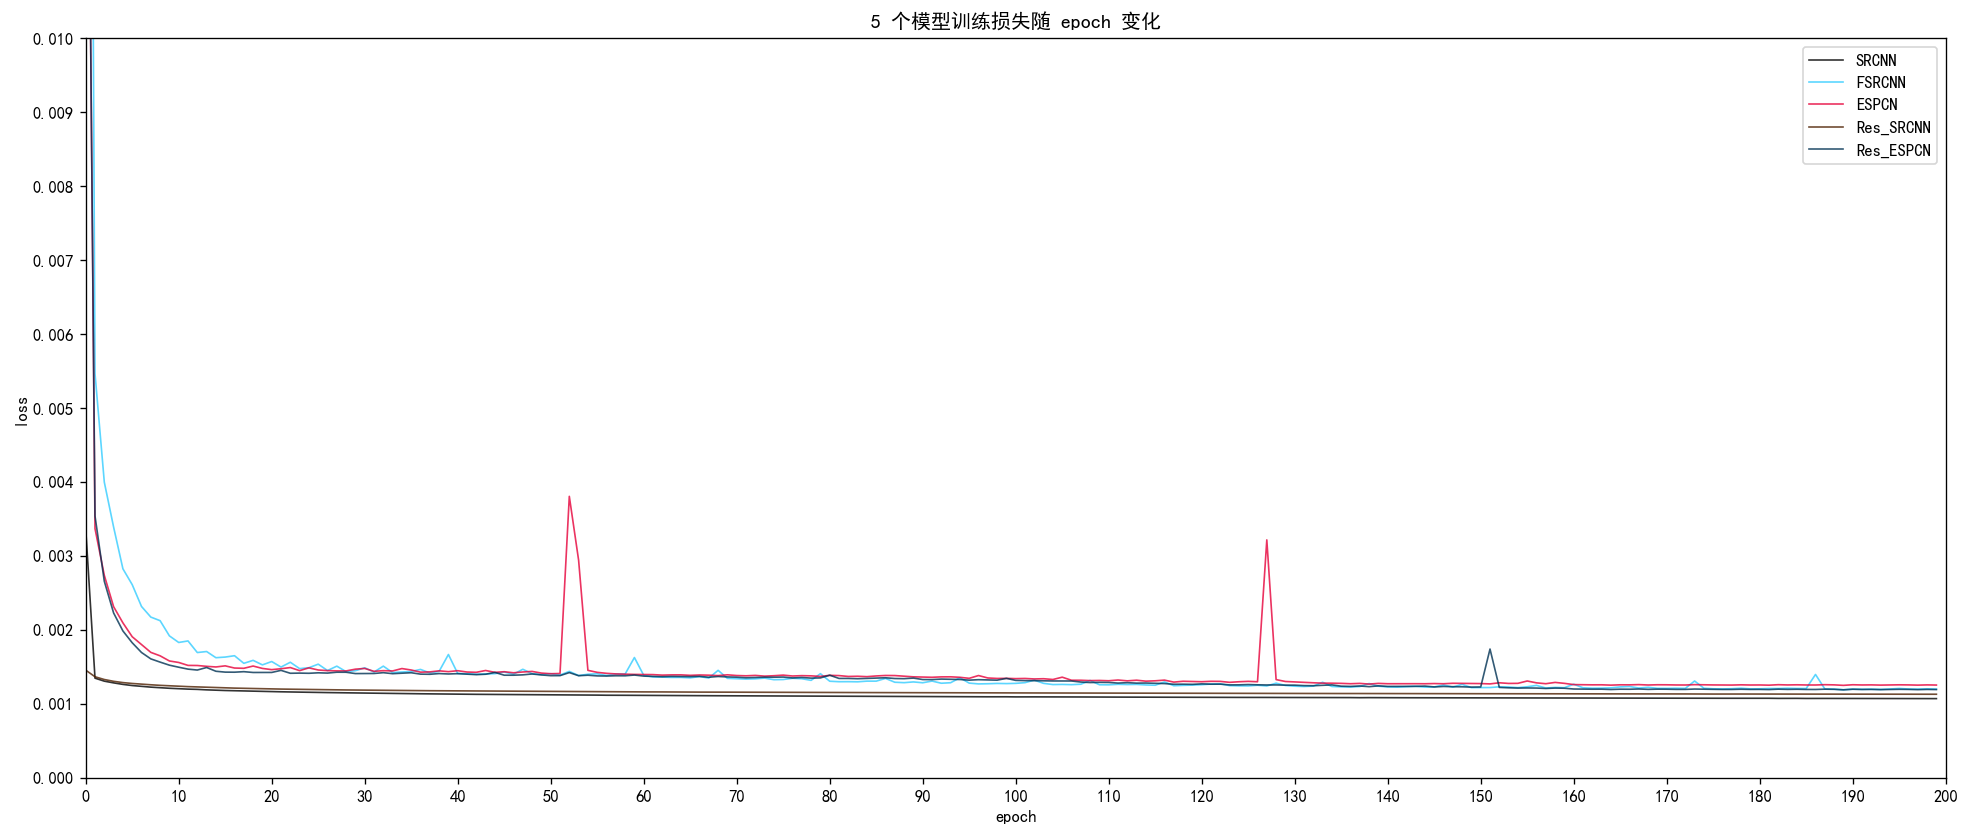

In [9]:
from pylab import *
import numpy as np
from matplotlib.pyplot import MultipleLocator

epochs = range(200)
loss_1 = np.load(r'outputs\SRCNN\train_loss.npy')
loss_2 = np.load(r'outputs\FSRCNN\train_loss.npy')
loss_3 = np.load(r'outputs\ESPCN\train_loss.npy')
loss_4 = np.load(r'outputs\Res_SRCNN\train_loss.npy')
loss_5 = np.load(r'outputs\Res_ESPCN\train_loss.npy')

plt.figure(figsize=(20,8), dpi=120)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 添加这条可以让图形显示中文
plt.rcParams['axes.unicode_minus'] = False 
x_major_locator=MultipleLocator(10) #把x轴的刻度间隔设置为x，并存在变量里
y_major_locator=MultipleLocator(0.001) #把y轴的刻度间隔设置为y，并存在变量里
ax=plt.gca() #ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(0,200)
plt.ylim(0,0.01)
plt.plot(epochs, loss_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
plt.plot(epochs, loss_2, 'ro-', color='#33CCFF', alpha=0.8, marker=None, linewidth=1, label='FSRCNN')
plt.plot(epochs, loss_3, 'ro-', color='#e60039', alpha=0.8, marker=None, linewidth=1, label='ESPCN')
plt.plot(epochs, loss_4, 'ro-', color='#4d1f00', alpha=0.8, marker=None, linewidth=1, label='Res_SRCNN')
plt.plot(epochs, loss_5, 'ro-', color='#003153', alpha=0.8, marker=None, linewidth=1, label='Res_ESPCN')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('5 个模型训练损失随 epoch 变化')
plt.show()

(3) 训练过程中，验证集 PSNR 随 epoch 的变化

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\4023783412.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, PSNR_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\4023783412.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, PSNR_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13392\4023783412.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, PSNR_2, 'ro-', color='#33CCFF', alpha=0.8, marker=None, linewidth=1

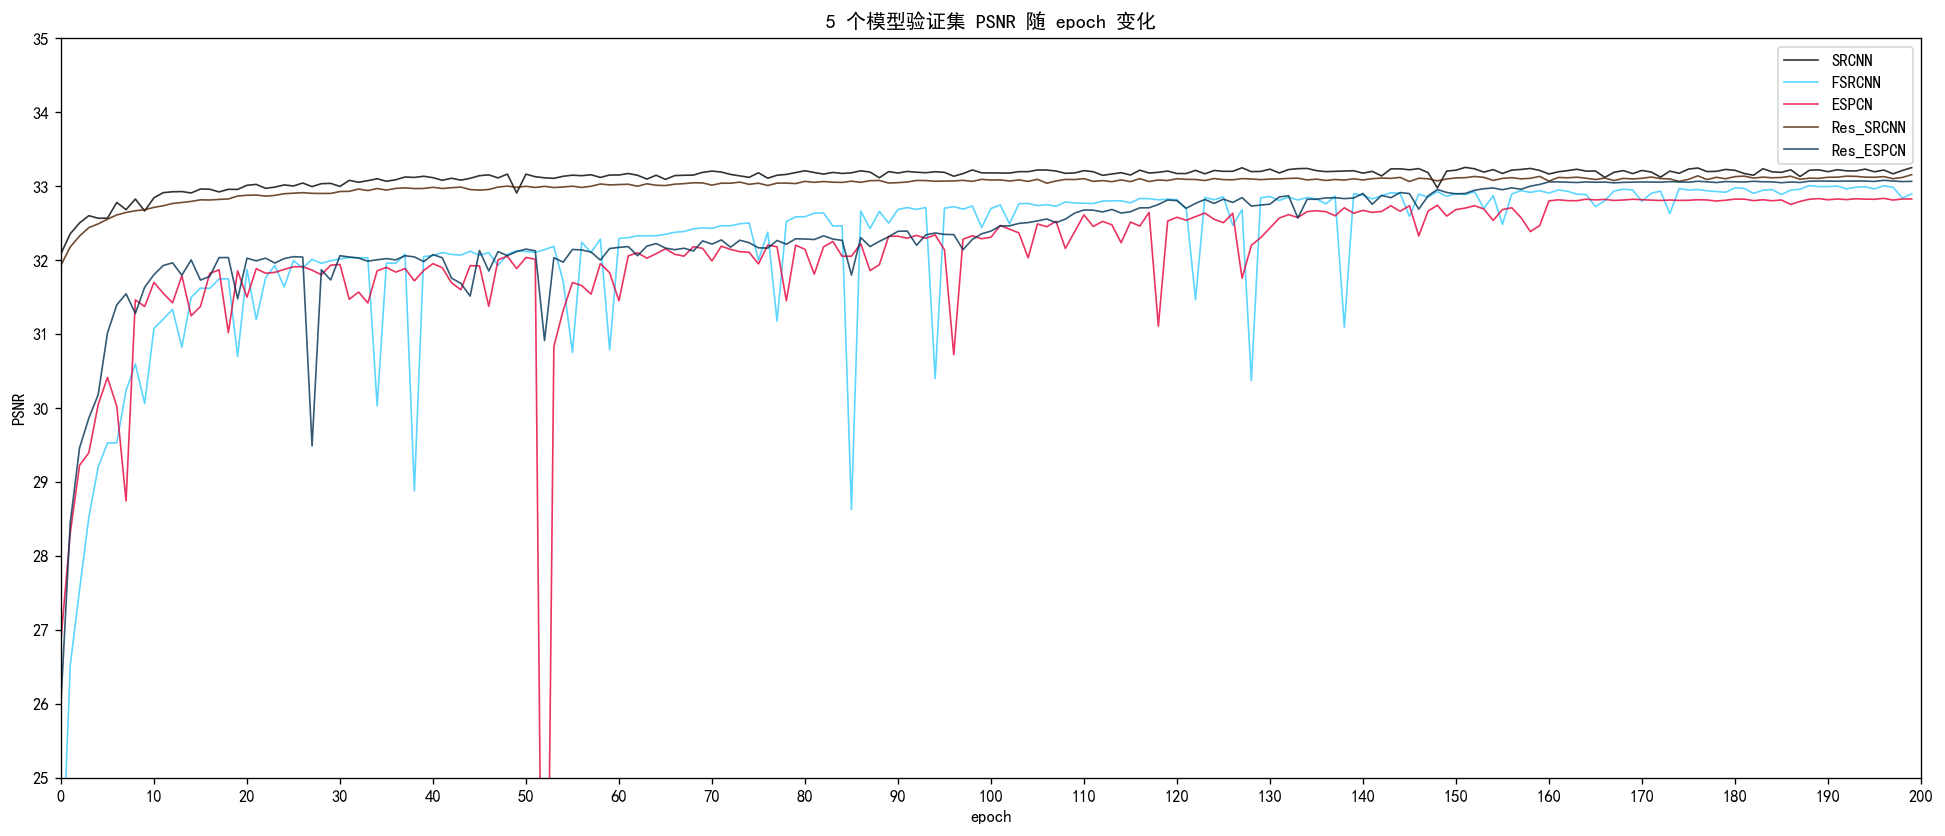

In [11]:
from pylab import *
import numpy as np
from matplotlib.pyplot import MultipleLocator

epochs = range(200)
PSNR_1 = np.load(r'outputs\SRCNN\eval_PSNR.npy')
PSNR_2 = np.load(r'outputs\FSRCNN\eval_PSNR.npy')
PSNR_3 = np.load(r'outputs\ESPCN\eval_PSNR.npy')
PSNR_4 = np.load(r'outputs\Res_SRCNN\eval_PSNR.npy')
PSNR_5 = np.load(r'outputs\Res_ESPCN\eval_PSNR.npy')

plt.figure(figsize=(20,8), dpi=120)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 添加这条可以让图形显示中文
plt.rcParams['axes.unicode_minus'] = False 
x_major_locator=MultipleLocator(10) #把x轴的刻度间隔设置为x，并存在变量里
y_major_locator=MultipleLocator(1) #把y轴的刻度间隔设置为y，并存在变量里
ax=plt.gca() #ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(0,200)
plt.ylim(25,35)
plt.plot(epochs, PSNR_1, 'ro-', color='#000000', alpha=0.8, marker=None, linewidth=1, label='SRCNN')
plt.plot(epochs, PSNR_2, 'ro-', color='#33CCFF', alpha=0.8, marker=None, linewidth=1, label='FSRCNN')
plt.plot(epochs, PSNR_3, 'ro-', color='#e60039', alpha=0.8, marker=None, linewidth=1, label='ESPCN')
plt.plot(epochs, PSNR_4, 'ro-', color='#4d1f00', alpha=0.8, marker=None, linewidth=1, label='Res_SRCNN')
plt.plot(epochs, PSNR_5, 'ro-', color='#003153', alpha=0.8, marker=None, linewidth=1, label='Res_ESPCN')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('PSNR')
plt.title('5 个模型验证集 PSNR 随 epoch 变化')
plt.show()